In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.weightstats import ttest_ind
import statsmodels.genmod.families.links as links
import statsmodels.stats.power as stats_power
from statsmodels.stats.power import TTestIndPower

import scipy.stats as stats
from scipy.stats import f_oneway

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import pingouin as pg
from pingouin import mediation_analysis
import os
import glob

In [2]:
def phantom_choices(option_1, option_2, option_3, choice, target_P, competitor_P):
    if((option_1 == "P_A") or (option_2 == "P_A") or (option_3 == "P_A")):
        if(choice == "A"):
            target_P = target_P + 1
        elif(choice == "B"):
            competitor_P = competitor_P + 1
    elif((option_1 == "P_B") or (option_2 == "P_B") or (option_3 == "P_B")):
        if(choice == "B"):
            target_P = target_P + 1
        elif(choice == "A"):
            competitor_P = competitor_P + 1
    return target_P, competitor_P

In [3]:
def getDecoyResponses(df, decoy_type):
    try:
        responses = df["Choice"].value_counts(normalize=True)[decoy_type]
    except KeyError:
        responses = 0
    return responses

def barGraphDecoys(mean_percentage, std_data, title):
    labels = ['Taget', 'Competitor', 'Decoy']
    x = np.arange(len(labels)) 
    y = mean_percentage
    error = std_data
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.bar(labels, y, 0.9, yerr=std_data, capsize=8)
    ax.set_ylim(0, 100)
    ax.set_ylabel('Percentage')
    ax.set_title(title)
    plt.show()    
    
def barGraphDecoys3(mean_percentage, std_data, title, mean_percentage_LC, std_data_LC, title_LC, mean_percentage_HC, std_data_HC, title_HC):
    labels = ['Taget', 'Competitor', 'Decoy']
    
    fig, ax = plt.subplots(1, 3, figsize=(14, 5))
    
    x = np.arange(len(labels)) 
    y = mean_percentage
    error = std_data
    
    ax[0].bar(labels, y, 0.9, yerr=std_data, capsize=8)
    ax[0].set_ylim(0, 100)
    ax[0].set_ylabel('Percentage')
    ax[0].set_title(title)
    
    y_LC = mean_percentage_LC
    error_LC = std_data_LC
    
    ax[1].bar(labels, y_LC, 0.9, yerr=std_data_LC, capsize=8)
    ax[1].set_ylim(0, 100)
    ax[1].set_ylabel('Percentage')
    ax[1].set_title(title_LC)
    
    y_HC = mean_percentage_HC
    error_HC = std_data_HC
    
    ax[2].bar(labels, y_HC, 0.9, yerr=std_data_HC, capsize=8)
    ax[2].set_ylim(0, 100)
    ax[2].set_ylabel('Percentage')
    ax[2].set_title(title_HC)
    
    plt.show()    
    

In [4]:
def simDecoy_Selection(option_1, option_2, option_3, choice, target_count, competitor_count, decoy_count):
    if((option_1 == "S_A") or (option_2 == "S_A") or (option_3) == "S_A"):
        if(choice == "A"):
            target_count = target_count + 1
        elif (choice == "S_A"):
            decoy_count = decoy_count + 1
        elif (choice == "B"):
            competitor_count = competitor_count + 1
        else: 
            print("Error")
    elif((option_1 == "S_B") or (option_2 == "S_B") or (option_3 == "S_B")):
        if(choice == "B"):
            target_count = target_count + 1
        elif (choice == "S_B"):
            decoy_count = decoy_count + 1
        elif (choice== "A"):
            competitor_count = competitor_count + 1
        else: 
            print("Error")
    return target_count, competitor_count, decoy_count
        
def comDecoy_Selection(option_1, option_2, option_3, choice, target_count, competitor_count, decoy_count):
    if((option_1 == "C_A") or (option_2 == "C_A") or (option_3) == "C_A"):
        if(choice == "A"):
            target_count = target_count + 1
        elif(choice == "C_A"):
            decoy_count = decoy_count + 1
        elif(choice == "B"):
            competitor_count = competitor_count + 1
        else: 
            print("Error!") 
    elif((option_1 == "C_B") or (option_2 == "C_B") or (option_3) == "C_B"):
        if(choice == "B"):
            target_count = target_count + 1
        elif(choice == "C_B"):
            decoy_count = decoy_count + 1
        elif(choice == "A"):
            competitor_count = competitor_count + 1
        else: 
            print("Error!")
    return target_count, competitor_count, decoy_count

def attDecoy_Selection(option_1, option_2, option_3, choice, target_count, competitor_count, decoy_count):
    if((option_1 == "A_A") or (option_2 == "A_A") or (option_3 == "A_A")):
        if(choice == "A"):
            target_count = target_count + 1
        elif(choice == "A_A"):
            decoy_count = decoy_count + 1
        elif(choice == "B"):
            competitor_count = competitor_count + 1
        else: 
            print("Error!")
    elif((option_1 == "A_B") or (option_2 == "A_B") or (option_3) == "A_B"):
        if(choice == "B"):
            target_count = target_count + 1
        elif(choice == "A_B"):
            decoy_count = decoy_count + 1
        elif(choice == "A"):
            competitor_count = competitor_count + 1
        else: 
            print("Error!") 
    return target_count, competitor_count, decoy_count

In [5]:
def partFreq_Decoy(decoy_df, decoy_type):
    
    freq_name = str(decoy_type + "(num)")
    perc_name = str(decoy_type + "(%)")
    
    freq_df = pd.DataFrame(columns=['PID', 'Target(num)', "Competitor(num)", freq_name, "Target(%)", "Competitor(%)", perc_name])
    
    participants_list = decoy_df["Survey_ID"].unique()
    
    for idx in participants_list:
        current_participant = decoy_df[decoy_df["Survey_ID"] == idx]
        current_participant = current_participant.reset_index()
        m, n = current_participant.shape 
        
        target_counter = 0
        competitor_counter = 0
        decoy_counter = 0
        
        for x in range(m):
            option_1 = current_participant["Option_1"][x]
            option_2 = current_participant["Option_2"][x]
            option_3 = current_participant["Option_3"][x]
            choice = current_participant["Choice"][x]
            
            if(decoy_type == "Sim_Decoy"):
                target_counter, competitor_counter, decoy_counter = simDecoy_Selection(option_1, option_2, option_3, choice, target_counter, competitor_counter, decoy_counter)
            elif(decoy_type == "Com_Decoy"):
                target_counter, competitor_counter, decoy_counter = comDecoy_Selection(option_1, option_2, option_3, choice, target_counter, competitor_counter, decoy_counter)
            elif(decoy_type == "Att_Decoy"):
                target_counter, competitor_counter, decoy_counter = attDecoy_Selection(option_1, option_2, option_3, choice, target_counter, competitor_counter, decoy_counter)
        
        current_participant_freq = pd.DataFrame(data={'PID': idx, 'Target(num)': target_counter, 'Competitor(num)': competitor_counter, freq_name: decoy_counter, 'Target(%)': (target_counter/m)*100, 'Competitor(%)': (competitor_counter/m)*100, perc_name: (decoy_counter/m)*100}, index=range(1))
        freq_df = freq_df.append(current_participant_freq, ignore_index = True)
    return freq_df

def partFreq_DecoyWCondition(decoy_df, decoy_type):
    
    freq_name = str(decoy_type + "(num)")
    perc_name = str(decoy_type + "(%)")
    
    freq_df = pd.DataFrame(columns=['PID', 'Target(num)', "Competitor(num)", freq_name, "Target(%)", "Competitor(%)", perc_name])
    
    participants_list = decoy_df["Survey_ID"].unique()
    
    for idx in participants_list:
        current_participant = decoy_df[decoy_df["Survey_ID"] == idx]
        current_participant = current_participant.reset_index()
        m, n = current_participant.shape 
        current_part_phant_condition = current_participant["PhantomCondition"][0]
        current_part_coup_condition = current_participant["CouplingCondition"][0]
        
        target_counter = 0
        competitor_counter = 0
        decoy_counter = 0
        
        for x in range(m):
            option_1 = current_participant["Option_1"][x]
            option_2 = current_participant["Option_2"][x]
            option_3 = current_participant["Option_3"][x]
            choice = current_participant["Choice"][x]
            
            if(decoy_type == "Sim_Decoy"):
                target_counter, competitor_counter, decoy_counter = simDecoy_Selection(option_1, option_2, option_3, choice, target_counter, competitor_counter, decoy_counter)
            elif(decoy_type == "Com_Decoy"):
                target_counter, competitor_counter, decoy_counter = comDecoy_Selection(option_1, option_2, option_3, choice, target_counter, competitor_counter, decoy_counter)
            elif(decoy_type == "Att_Decoy"):
                target_counter, competitor_counter, decoy_counter = attDecoy_Selection(option_1, option_2, option_3, choice, target_counter, competitor_counter, decoy_counter)
        
        current_participant_freq = pd.DataFrame(data={'PID': idx, 'Target(num)': target_counter, 'Competitor(num)': competitor_counter, freq_name: decoy_counter, 'Target_perc': (target_counter/m)*100, 'Competitor_perc': (competitor_counter/m)*100, perc_name: (decoy_counter/m)*100, 'PhantomCondition':current_part_phant_condition, 'CouplingCondition':current_part_coup_condition}, index=range(1))
        freq_df = freq_df.append(current_participant_freq, ignore_index = True)
    return freq_df

def itemFreq_Decoy(decoy_df, decoy_type):
    
    freq_name = str(decoy_type + "(num)")
    perc_name = str(decoy_type + "(%)")
    
    item_list = decoy_df["Item"].unique()
    
    freq_df = pd.DataFrame(columns=['Item', 'Target(num)', "Competitor(num)", freq_name, "Target(%)", "Competitor(%)", perc_name])
    
    for item in item_list:
        current_item = decoy_df[decoy_df["Item"] == item]
        current_item = current_item.reset_index()
        m, n = current_item.shape 
        
        target_counter = 0
        competitor_counter = 0
        decoy_counter = 0
        
        for x in range(m):
            option_1 = current_item["Option_1"][x]
            option_2 = current_item["Option_2"][x]
            option_3 = current_item["Option_3"][x]
            choice = current_item["Choice"][x]
            
            if(decoy_type == "Sim_Decoy"):
                target_counter, competitor_counter, decoy_counter = simDecoy_Selection(option_1, option_2, option_3, choice, target_counter, competitor_counter, decoy_counter)
            elif(decoy_type == "Com_Decoy"):
                target_counter, competitor_counter, decoy_counter = comDecoy_Selection(option_1, option_2, option_3, choice, target_counter, competitor_counter, decoy_counter)
            elif(decoy_type == "Att_Decoy"):
                target_counter, competitor_counter, decoy_counter = attDecoy_Selection(option_1, option_2, option_3, choice, target_counter, competitor_counter, decoy_counter)
        #Might add code to get sem.
        target_perc = np.round(((target_counter/m)*100), 1)
        competitor_perc = np.round(((competitor_counter/m)*100), 1)
        decoy_perc = np.round(((decoy_counter/m)*100), 1)
        current_item_freq = pd.DataFrame(data={'Item': item, 'Target(num)': target_counter, 'Competitor(num)': competitor_counter, freq_name: decoy_counter, 'Target(%)': target_perc, 'Competitor(%)': competitor_perc, perc_name: decoy_perc}, index=range(1))
        freq_df = freq_df.append(current_item_freq, ignore_index = True)
    return freq_df

def partFreq_PhantomDecoy(decoy_df):
    
    freq_df = pd.DataFrame(columns=['PID', 'Target(num)', "Competitor(num)", "Target(%)", "Competitor(%)"])
    
    participants_list = decoy_df["Survey_ID"].unique()
    
    for idx in participants_list:
        current_participant = decoy_df[decoy_df["Survey_ID"] == idx]
        current_participant = current_participant.reset_index()
        m, n = current_participant.shape 
        
        target_counter = 0
        competitor_counter = 0
        
        for x in range(m):
            option_1 = current_participant["Option_1"][x]
            option_2 = current_participant["Option_2"][x]
            option_3 = current_participant["Option_3"][x]
            choice = current_participant["Choice"][x]
            
            target_counter, competitor_counter = phantom_choices(option_1, option_2, option_3, choice, target_counter, competitor_counter)
        
        current_participant_freq = pd.DataFrame(data={'PID': idx, 'Target(num)': target_counter, 'Competitor(num)': competitor_counter, 'Target(%)': (target_counter/m)*100, 'Competitor(%)': (competitor_counter/m)*100}, index=range(1))
        freq_df = freq_df.append(current_participant_freq, ignore_index = True)
    return freq_df

def partFreq_PhantomDecoyWCondition(decoy_df):
    
    freq_df = pd.DataFrame(columns=['PID', 'Target(num)', "Competitor(num)", "Target(%)", "Competitor(%)"])
    
    participants_list = decoy_df["Survey_ID"].unique()
    
    for idx in participants_list:
        current_participant = decoy_df[decoy_df["Survey_ID"] == idx]
        current_participant = current_participant.reset_index()
        m, n = current_participant.shape 
        current_part_phant_condition = current_participant["PhantomCondition"][0]
        current_part_coup_condition = current_participant["CouplingCondition"][0]
        
        target_counter = 0
        competitor_counter = 0
        
        for x in range(m):
            option_1 = current_participant["Option_1"][x]
            option_2 = current_participant["Option_2"][x]
            option_3 = current_participant["Option_3"][x]
            choice = current_participant["Choice"][x]
            
            target_counter, competitor_counter = phantom_choices(option_1, option_2, option_3, choice, target_counter, competitor_counter)
        
        current_participant_freq = pd.DataFrame(data={'PID': idx, 'Target(num)': target_counter, 'Competitor(num)': competitor_counter, 'Target_perc': (target_counter/m)*100, 'Competitor_perc_': (competitor_counter/m)*100, 'PhantomCondition':current_part_phant_condition, 'CouplingCondition':current_part_coup_condition}, index=range(1))
        freq_df = freq_df.append(current_participant_freq, ignore_index = True)
    return freq_df

def itemFreq_PhantomDecoy(decoy_df):
    
    freq_df = pd.DataFrame(columns=['Item', 'Target(num)', "Competitor(num)", "Target(%)", "Competitor(%)"])
    
    item_list = decoy_df["Item"].unique()
    
    for item in item_list:
        current_item = decoy_df[decoy_df["Item"] == item]
        current_item = current_item.reset_index()
        m, n = current_item.shape 
        
        target_counter = 0
        competitor_counter = 0
        
        for x in range(m):
            option_1 = current_item["Option_1"][x]
            option_2 = current_item["Option_2"][x]
            option_3 = current_item["Option_3"][x]
            choice = current_item["Choice"][x]
            
            target_counter, competitor_counter = phantom_choices(option_1, option_2, option_3, choice, target_counter, competitor_counter)
        target_perc = np.round((target_counter/m)*100, 1)
        competitor_perc = np.round((competitor_counter/m)*100, 1)
        current_participant_freq = pd.DataFrame(data={'Item': item, 'Target(num)': target_counter, 'Competitor(num)': competitor_counter, 'Target(%)': target_perc, 'Competitor(%)': competitor_perc}, index=range(1))
        freq_df = freq_df.append(current_participant_freq, ignore_index = True)
    return freq_df
            


## Load and Pre-process data

In [6]:
# Now open a directory/folder "/zDemo_data"
fd = os.open("Participants_data", os.O_RDONLY)

# Use os.fchdir() method to change the dir/folder
os.fchdir(fd)

# Safe check- Print current working directory
print("Current working dir : %s" % os.getcwd())

Current working dir : /Users/luisalvarez/Documents/Decoy/22AY_01_Code/Participants_data


In [7]:
# use glob to get all the csv files 
# in the folder
path = os.getcwd()
csv_files = glob.glob(os.path.join(path, "*.csv"))

# Create DataFrame storing the demographic info 
col_names = ['Age', 'Sex', 'Race', 'Ethnicity', 'Date', 'PID', 'SurveyID', 'Email', 'CouplingCondition', 'PhantomCondition']
demographic_info_df = pd.DataFrame(columns=col_names)

for file in csv_files: 
    df = pd.read_csv(file)
    # Check if first row contains demographic info
                      
    if((df["Gender"][0] == "Male") or (df["Gender"][0] == "Female") or (df["Gender"][0] == "Other")): 
        Age = df["Age"][0]
        Sex = df["Gender"][0]
        Race = df["Race"][0]
        Ethnicity = df["Ethnicity"][0]
        Date = df["Date"][0]
        PID = df["User_PID"][0]
        SurveyID = df["Survey_ID"][0]
        Email = df["User_email"][0]
        CouplingCondition = df["Coupling"][0]
        PhantomCondition = df["Phantom_condition"][0]
        
        demo_col = pd.DataFrame(data={'Age': Age, 'Sex': Sex, 'Race': Race, 'Ethnicity': Ethnicity, 'Date': Date, 'PID': PID, 'SurveyID': SurveyID, 'Email': Email, 'CouplingCondition': CouplingCondition,  'PhantomCondition': PhantomCondition}, index=range(1))
        demographic_info_df = demographic_info_df.append(demo_col, ignore_index = True)
    else: 
        print("Error: " + str(file))

demographic_info_df.head(40)


,Age,Sex,Race,Ethnicity,Date,PID,SurveyID,Email,CouplingCondition,PhantomCondition
0,18,Female,Not_hispanic,White,04/11/2022,16938385,40781,ehefner@ucsd.edu,High coupling,Highly_desirable
1,21,Female,Not_hispanic,East_Asian,04/08/2022,17212732,40447,kyc002@ucsd.edu,Low coupling,Highly_desirable
2,19,Male,Hispanic,Hispanic,05/19/2022,16292970,41454,jpcruz@ucsd.edu,Low coupling,Undesirable
3,19,Female,Not_hispanic,East_Asian,05/20/2022,16430620,37956,kdelapen@ucsd.edu,Low coupling,Weakly_desirable
4,23,Female,Not_hispanic,White,04/07/2022,16083027,34796,mengel@ucsd.edu,Low coupling,Weakly_desirable
5,23,Male,Not_hispanic,White,05/22/2022,15402507,44066,jtschnec@ucsd.edu,High coupling,Weakly_desirable
6,22,Female,Not_hispanic,East_Asian,04/11/2022,15501740,33898,lnn019@ucsd.edu,High coupling,Weakly_desirable
7,22,Male,Not_hispanic,East_Asian,04/11/2022,16587075,37993,bgfang@ucsd.edu,High coupling,Undesirable
8,21,Female,Not_hispanic,White,05/23/2022,16155105,33491,kjevans@ucsd.edu,Low coupling,Undesirable
9,19,Female,Not_hispanic,East_Asian,05/20/2022,16297216,38313,lballest@ucsd.edu,High coupling,Undesirable


In [239]:
demographic_info_df[demographic_info_df["Sex"] == "Female"].shape
#.count()

(202, 10)

In [8]:
#Pre-process data 

all_responses = pd.DataFrame(columns=['Decoy', 'Item', 'Option_1', 'Option_2', 'Option_3', 'Choice', 'CatchTrials', 'Deliberation_RT', 'Choice_RT', 'Too_Slow'])

for file in csv_files: 
    df = pd.read_csv(file)
    Survey_ID = df["Survey_ID"][0]
    phantom_condition = df["Phantom_condition"][0]
    coupling_condition = df["Coupling"][0]
    
    #Check shape of file
    n, m = df.shape
    for x in range(n):
        # Select rows corresponding to choices.
        if((df["User_email"][x]!="C") and (df["User_email"][x]!="F") and (df["User_email"][x]!="A") and (df["User_email"][x]!="S") and (df["User_email"][x]!="P")): #pd.isna(df["Item"][x])
            df.drop([x])
        else: 
            decoy = df["User_email"][x]
            item = df["Gender"][x]
            Option_1 = df["Age"][x]
            Option_2 = df["Phantom_condition"][x]
            Option_3 = df["Race"][x]
            Choice = df["User_PID"][x]
            CatchTrials = df["Date"][x]
            Deliberation_RT = df["Survey_ID"][x]
            Choice_RT = df["Ethnicity"][x]
            Too_Slow = df["Coupling"][x]
            
            demo_col = pd.DataFrame(data={'Decoy': decoy, 'Item': item, 'Option_1': Option_1, 'Option_2': Option_2, 'Option_3': Option_3, 'Choice': Choice, 'CatchTrials': CatchTrials, 'Deliberation_RT': Deliberation_RT, 'Choice_RT': Choice_RT, 'Too_Slow': Too_Slow, 'Survey_ID': Survey_ID, 'CouplingCondition': coupling_condition, 'PhantomCondition': phantom_condition}, index=range(1))
            all_responses = all_responses.append(demo_col, ignore_index = True)

print(all_responses.shape)
all_responses.head(10)

(27300, 13)


,Decoy,Item,Option_1,Option_2,Option_3,Choice,CatchTrials,Deliberation_RT,Choice_RT,Too_Slow,Survey_ID,CouplingCondition,PhantomCondition
0,F,Kitchen Scale,A,C,B,C,NaN,10000,620,0,40781,High coupling,Highly_desirable
1,C,Baby crib,C_A,B,A,A,NaN,10000,389.0,0,40781,High coupling,Highly_desirable
2,S,Baby high chair,A,B,S_B,B,NaN,10000,761,0,40781,High coupling,Highly_desirable
3,A,Leaf Blower,A,B,A_B,A,NaN,10000,308,0,40781,High coupling,Highly_desirable
4,P,Wifi extender,A,B,P_B,A,NaN,10000,586.0,0,40781,High coupling,Highly_desirable
5,P,Electric mop,A,P_B,B,B,NaN,10000,451,0,40781,High coupling,Highly_desirable
6,C,Smart lock,C_B,A,B,B,NaN,10000,285.0,0,40781,High coupling,Highly_desirable
7,S,Air Fryer Oven,B,S_A,A,A,NaN,10000,301,0,40781,High coupling,Highly_desirable
8,F,Stun gun,B,A,C,B,NaN,10000,297,0,40781,High coupling,Highly_desirable
9,A,Smart bulb,A,B,A_A,A,NaN,10000,371,0,40781,High coupling,Highly_desirable


In [9]:
# Pre process RT data, turn 'str' to NaN, then remove NaN.
all_responses["Choice_RT"] = pd.to_numeric(all_responses["Choice_RT"], errors='coerce')
RT_df = all_responses["Choice_RT"].dropna()
RT_df = RT_df/1000

In [10]:
#RT_df.head()

In [11]:
Participants_PIDs = all_responses["Survey_ID"].unique()
total_n = int(len(Participants_PIDs))

print(Participants_PIDs)
print("Total number of particiants: " + str(total_n))

number_of_low_coupling = demographic_info_df["CouplingCondition"].str.count("Low coupling").sum()
print("Total number of participants 'low coupling':" + str(number_of_low_coupling))  

number_of_high_coupling = demographic_info_df["CouplingCondition"].str.count("High coupling").sum()
print("Total number of participants 'high coupling':" + str(number_of_high_coupling))  

['40781' '40447' '41454' '37956' '34796' '44066' '33898' '37993' '33491'
 '38313' '36203' '36951' '39630' '40448' '34943' '39618' '40548' '38543'
 '34741' '40016' '39056' '40719' '33553' '38642' '43019' '41241' '41067'
 '38284' '36391' '44198' '32388' '30026' '40413' '30471' '40469' '35225'
 '38810' '40763' '36413' '39312' '37978' '40815' '36300' '36432' '43075'
 '38533' '39540' '36123' '32575' '40703' '34549' '34863' '43026' '37845'
 '36013' '28943' '38236' '40446' '41031' '38045' '29949' '42119' '42405'
 '39092' '41970' '40309' '41900' '43993' '42195' '42626' '37059' '37166'
 '33032' '35108' '37813' '38611' '42961' '32172' '35606' '39232' '41387'
 '42504' '32830' '31348' '32366' '35725' '35868' '34072' '31893' '32342'
 '40441' '33506' '41860' '34504' '40762' '40637' '42977' '39841' '41785'
 '44083' '37004' '43188' '32059' '35956' '37555' '33918' '30973' '43223'
 '35851' '36926' '40706' '41319' '37251' '42530' '35436' '40082' '35271'
 '39494' '42993' '42606' '34705' '44139' '38529' '3

## Participants RT

In [12]:
# Checking mean response time

rt_mean = RT_df.mean()
rt_mean = rt_mean#/1000

print("Group mean response time: " + str(round(rt_mean, 2)) + " sec.")

Group mean response time: 1.53 sec.


In [13]:
# Checking mean response time per participant 

group_rt_df = pd.DataFrame(columns=['PID', 'Mean_RT (sec)'])

for x in Participants_PIDs:
    participant_pid = str(x)
    participant_rt = all_responses[all_responses["Survey_ID"] == x]["Choice_RT"].apply(float).mean()/1000
    participant_rt = round(participant_rt, 2)
    current_p_df = pd.DataFrame(data={'PID': participant_pid, 'Mean_RT (sec)': participant_rt}, index=range(1))
    group_rt_df = group_rt_df.append(current_p_df, ignore_index = True)

#group_rt_df.head(40)

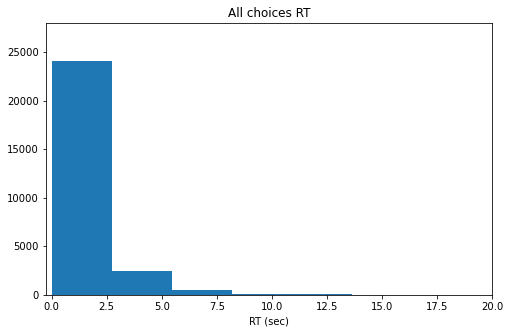

In [14]:
plt.subplots(figsize=(8, 5))
plt.hist(RT_df, bins=700)
plt.title('All choices RT')
plt.xlabel('RT (sec)')
plt.xlim(-.25, 20)
plt.ylim(0, 28000)

plt.show()


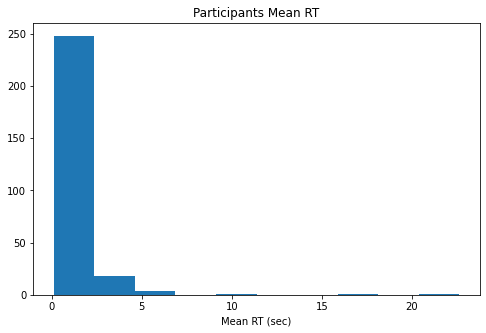

In [15]:
plt.subplots(figsize=(8, 5))
plt.hist(group_rt_df["Mean_RT (sec)"], bins=10)
plt.title('Participants Mean RT')
plt.xlabel('Mean RT (sec)')
plt.show()


## Catch Trials 

In [16]:
# Checking filler/catch trials work as expected.

filler_total = all_responses[all_responses["Decoy"] =="F"]["Choice"].count()
filler_catch = all_responses[all_responses["Decoy"] =="F"]["Choice"].str.count("C").sum()
filler_miss = all_responses[all_responses["Decoy"] =="F"]["Choice"].str.count("B").sum() + all_responses[all_responses["Decoy"] =="F"]["Choice"].str.count("A").sum()
print("Total number of catch trials: " + str(filler_total))
print("Total 'catch trials' correct: " + str(filler_catch))
print("Total 'catch trials' incorrect': " + str(filler_miss))

print("\n Correct trials avg: " + str(round(filler_catch/filler_total, 2)*100) + "%")
print("\n Incorrect trials avg: " + str(round(filler_miss/filler_total, 2)*100) + "%")


Total number of catch trials: 5460
Total 'catch trials' correct: 3837
Total 'catch trials' incorrect': 1623

 Correct trials avg: 70.0%

 Incorrect trials avg: 30.0%


In [17]:
# Each participants catch trials info

group_catch_df = pd.DataFrame(columns=['PID', 'Correct(num)', 'Incorrect(num)', 'Correct(%)', 'Incorrect(%)'])

for x in Participants_PIDs:
    participant_pid = str(x)
    current_part_catch_df = all_responses[all_responses["Survey_ID"] == x]
    current_part_catch_df = current_part_catch_df[current_part_catch_df["Decoy"] =="F"]
    current_part_total_trials = current_part_catch_df["Choice"].count()
    current_part_catch_freq = current_part_catch_df["Choice"].str.count("C").sum()
    current_part_miss_freq = current_part_catch_df["Choice"].str.count("B").sum() + current_part_catch_df["Choice"].str.count("A").sum()
    current_part_catch_perc = current_part_catch_freq/current_part_total_trials
    current_part_miss_perc = current_part_miss_freq/current_part_total_trials
    
    current_p_df = pd.DataFrame(data={'PID': participant_pid, 'Correct(num)': current_part_catch_freq, "Incorrect(num)": current_part_miss_freq, "Correct(%)": current_part_catch_perc*100, "Incorrect(%)": current_part_miss_perc*100}, index=range(1))
    group_catch_df = group_catch_df.append(current_p_df, ignore_index = True)
    
#group_catch_df.head(40)


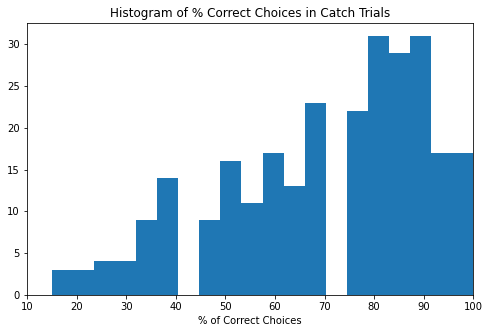

In [18]:
plt.subplots(figsize=(8, 5))
plt.hist(group_catch_df["Correct(%)"], bins=20)
plt.title('Histogram of % Correct Choices in Catch Trials')
plt.xlabel('% of Correct Choices')
plt.xlim(10, 100)
plt.show()


In [19]:
catch_items_df = all_responses[all_responses["Decoy"] =="F"]
catch_summary_df = pd.DataFrame(columns=['Item', 'Correct(num)', 'Incorrect(num)', 'Correct(%)', 'Incorrect(%)', "Times_Encountered"])

catch_items_list = catch_items_df["Item"].unique()

for item in catch_items_list: 
    
    current_item_catch_df = catch_items_df[catch_items_df["Item"] == item]
    times_encountered = current_item_catch_df["Choice"].count()
    current_item_catch_freq = current_item_catch_df["Choice"].str.count("C").sum()
    current_item_miss_freq = current_item_catch_df["Choice"].str.count("B").sum() + current_item_catch_df["Choice"].str.count("A").sum()
    current_item_catch_perc = current_item_catch_freq/times_encountered
    current_item_miss_perc = current_item_miss_freq/times_encountered
    
    current_item_catch_perc = np.round(current_item_catch_perc, 2)
    current_item_miss_perc = np.round(current_item_miss_perc, 2)
    
    current_i_df = pd.DataFrame(data={'Item': item, 'Correct(num)': current_item_catch_freq, "Incorrect(num)": current_item_miss_freq, "Correct(%)": current_item_catch_perc*100, "Incorrect(%)": current_item_miss_perc*100, "Times_Encountered":times_encountered}, index=range(1))
    catch_summary_df = catch_summary_df.append(current_i_df, ignore_index = True)

catch_summary_df.head(20)

,Item,Correct(num),Incorrect(num),Correct(%),Incorrect(%),Times_Encountered
0,Kitchen Scale,165,94,64.0,36.0,259
1,Stun gun,170,107,61.0,39.0,277
2,Hearing aid,187,88,68.0,32.0,275
3,Alarm clock,184,84,69.0,31.0,268
4,Megaphone,198,63,76.0,24.0,261
5,Thermometer gun,211,60,78.0,22.0,271
6,Outdoor TV antenna,201,72,74.0,26.0,273
7,Wagon cart,180,85,68.0,32.0,265
8,Baby rocker,205,56,79.0,21.0,261
9,Inflatable baby pool,207,74,74.0,26.0,281


### Filter/remove participants with Correct(%) < 80

In [20]:
participants_to_filter_out = group_catch_df[group_catch_df["Correct(%)"] < 80]["PID"].unique()

print("Participants to filter out: " +  str(participants_to_filter_out))

Participants to filter out: ['37956' '38313' '36203' '36951' '40448' '34943' '40548' '38543' '40016'
 '40719' '38642' '43019' '32388' '30471' '40469' '35225' '40763' '36413'
 '39312' '40815' '43075' '38533' '39540' '36123' '32575' '40703' '34549'
 '34863' '37845' '38236' '38045' '42119' '41970' '43993' '42195' '42626'
 '33032' '37813' '38611' '35606' '41387' '32830' '31348' '32366' '31893'
 '32342' '34504' '40762' '42977' '41785' '44083' '37004' '32059' '33918'
 '30973' '36926' '40706' '42530' '35436' '40082' '42993' '42606' '34705'
 '44139' '37455' '35636' '43929' '27316' '38896' '41811' '36605' '33717'
 '31478' '40584' '39603' '39503' '31393' '42563' '33214' '32218' '28973'
 '39449' '38627' '43126' '38919' '27691' '42674' '32912' '41850' '35788'
 '41077' '38324' '40440' '41048' '42906' '38022' '41706' '40220' '40571'
 '38671' '36723' '26982' '36592' '33012' '34547' '35617' '37299' '39366'
 '39031' '44188' '35920' '40996' '31077' '28283' '41650' '43646' '41910'
 '41036' '40588' '37509

In [21]:
all_responses = all_responses[all_responses.Survey_ID.isin(participants_to_filter_out) == False]


In [22]:
Participants_PIDs = all_responses["Survey_ID"].unique()
total_n = int(len(Participants_PIDs))

print("Total number of particiants: " + str(total_n))
print(Participants_PIDs)

Total number of particiants: 125
['40781' '40447' '41454' '34796' '44066' '33898' '37993' '33491' '39630'
 '39618' '34741' '39056' '33553' '41241' '41067' '38284' '36391' '44198'
 '30026' '40413' '38810' '37978' '36300' '36432' '43026' '36013' '28943'
 '40446' '41031' '29949' '42405' '39092' '40309' '41900' '37059' '37166'
 '35108' '42961' '32172' '39232' '42504' '35725' '35868' '34072' '40441'
 '33506' '41860' '40637' '39841' '43188' '35956' '37555' '43223' '35851'
 '41319' '37251' '35271' '39494' '38529' '27372' '43507' '36122' '34906'
 '42344' '37478' '43641' '39600' '41830' '44180' '44082' '36585' '36195'
 '41663' '42365' '36354' '44172' '40514' '33494' '36878' '40539' '37202'
 '36812' '42146' '41969' '40551' '34275' '33428' '40314' '42234' '43687'
 '35998' '41482' '43544' '37550' '43101' '41171' '30586' '35848' '35117'
 '36984' '30067' '43445' '32743' '42552' '35602' '40116' '36020' '33718'
 '37439' '41469' '39463' '41840' '38312' '31833' '32946' '39492' '43052'
 '32782' '31280' '

In [23]:
# Get the number of participants for each phantom condition.

decoy_P_df = all_responses[all_responses["Decoy"] == "P"]
decoy_P_HD_df = decoy_P_df[decoy_P_df["PhantomCondition"] == "Highly_desirable"].reset_index()
decoy_P_WD_df = decoy_P_df[decoy_P_df["PhantomCondition"] == "Weakly_desirable"].reset_index()
decoy_P_U_df = decoy_P_df[decoy_P_df["PhantomCondition"] == "Undesirable"].reset_index()
Phantom_HD_part_total = decoy_P_HD_df["Survey_ID"].unique()
Phantom_WD_part_total = decoy_P_WD_df["Survey_ID"].unique()
Phantom_U_part_total = decoy_P_U_df["Survey_ID"].unique()

number_of_HD = int(len(Phantom_HD_part_total))
number_of_WD = int(len(Phantom_WD_part_total))
number_of_U = int(len(Phantom_U_part_total))

print("Total number of participants in 'Highly Desirable': " + str(int(len(Phantom_HD_part_total))))
print("Total number of participants in 'Weakly Desirable': " + str(int(len(Phantom_WD_part_total))))
print("Total number of participants in 'Undesirable': " + str(int(len(Phantom_U_part_total))))

Total number of participants in 'Highly Desirable': 40
Total number of participants in 'Weakly Desirable': 46
Total number of participants in 'Undesirable': 39


## Displaying Decoys in space

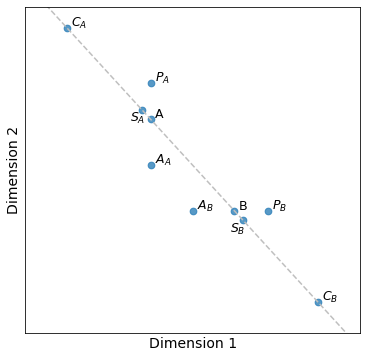

'\nH1: PC1 indicates that similarity effect diminished attraction and compromise effect. \nH2 (not mutually exclusive): PC2 suggests higher convexity can lead to larger compromise effect but smaller\nattraction and similarity effects.\n'

In [236]:
x = np.array([14, 16, 14, 16.8, 14, 15, 13.8, 16.2, 12, 18])
y = np.array([18, 12, 20.4, 12, 15, 12, 18.6, 11.4, 24, 6])

#x1 = np.array([14, 16, 13.8, 16.2, 12, 18])
x1 = np.array([0, 20])
#y1 = np.array([18, 12, 18.6, 11.4, 24, 6])
y1 = np.array([60, 0])

fig, ax = plt.subplots(figsize=(6, 6))

#"$Y_{axis}$"


ax.scatter(x, y, s=45, alpha=.75)
ax.annotate("A", (x[0]+.1, y[0]+.1), size=12.5)
ax.annotate("B", (x[1]+.1, y[1]+.1), size=12.5)
ax.annotate("$P_{A}$", (x[2]+.1, y[2]+.1), size=12.5)
ax.annotate("$P_{B}$", (x[3]+.1, y[3]+.1), size=12.5)
ax.annotate("$A_{A}$", (x[4]+.1, y[4]+.1), size=12.5)
ax.annotate("$A_{B}$", (x[5]+.1, y[5]+.1), size=12.5)
ax.annotate("$S_{A}$", (x[6]-.3, y[6]-.7), size=12.5)
ax.annotate("$S_{B}$", (x[7]-.3, y[7]-.8), size=12.5)
ax.annotate("$C_{A}$", (x[8]+.1, y[8]+.1), size=12.5)
ax.annotate("$C_{B}$", (x[9]+.1, y[9]+.1), size=12.5)
ax.plot(x1, y1, color='0.75', linestyle='dashed')

ax.set_xlim(11, 19)
ax.set_ylim(4, 25.4)
ax.set_xticks([])
ax.set_yticks([])
ax.set_ylabel('Dimension 2', size=14)
ax.set_xlabel('Dimension 1', size=14)
plt.show()


"""
H1: PC1 indicates that similarity effect diminished attraction and compromise effect. 
H2 (not mutually exclusive): PC2 suggests higher convexity can lead to larger compromise effect but smaller
attraction and similarity effects.
"""

In [ ]:
x = np.array([14, 16, 14, 16.8, 14, 15, 13.8, 16.2, 12, 18])
y = np.array([18, 12, 20.4, 12, 15, 12, 18.6, 11.4, 24, 6])

decoy_figure_df = pd.DataFrame({'D1': x,
                           'D2': y}) 

fig, ax = plt.subplots(figsize=(5, 5))

sns.scatterplot(data=decoy_figure_df, x="D1", y="D2", sizes=(100, 100))
#decoys_display =
#decoys_display.set(ylim=(4, 25.4))
#decoys_display.set(xlim=(11, 19))

ax.set_xlim(11, 19)
ax.set_ylim(4, 25.4)

plt.show()

## Similarity Decoy

In [25]:
def get_decoy_stats(df, kind, participants_num):
    
    mean_i = round(df[kind].mean(), 2)
    std_i = df[kind].std()
    sem_i = round((std_i/np.sqrt(participants_num)), 2)
    
    return mean_i, std_i, sem_i

In [26]:
decoy_S_df = all_responses[all_responses["Decoy"] == "S"]

# Filter out biased items.
similarity_biased_items = ["Baby high chair", "Metal detector", "Vacuum"]
decoy_S_df = decoy_S_df[~decoy_S_df.Item.isin(similarity_biased_items) == True]
# Removing biased items increases "Target(%)" 

decoy_S_df_LowC = decoy_S_df[decoy_S_df["CouplingCondition"] == "Low coupling"]
decoy_S_df_HighC = decoy_S_df[decoy_S_df["CouplingCondition"] == "High coupling"]
decoy_S_HD_df = decoy_S_df[decoy_S_df["PhantomCondition"] == "Highly_desirable"]
decoy_S_WD_df = decoy_S_df[decoy_S_df["PhantomCondition"] == "Weakly_desirable"]
decoy_S_U_df = decoy_S_df[decoy_S_df["PhantomCondition"] == "Undesirable"]

decoy_S_df = decoy_S_df.reset_index()
decoy_S_df_LowC = decoy_S_df_LowC.reset_index()
decoy_S_df_HighC = decoy_S_df_HighC.reset_index()
decoy_S_HD_df = decoy_S_HD_df.reset_index()
decoy_S_WD_df = decoy_S_WD_df.reset_index()
decoy_S_U_df = decoy_S_U_df.reset_index()

group_sim_freq_df = partFreq_Decoy(decoy_S_df, "Sim_Decoy")
group_sim_freq_with_condition_df = partFreq_DecoyWCondition(decoy_S_df, "Sim_Decoy")
group_sim_freq_df_LowC = partFreq_Decoy(decoy_S_df_LowC, "Sim_Decoy")
group_sim_freq_df_HighC = partFreq_Decoy(decoy_S_df_HighC, "Sim_Decoy")
group_sim_HD_freq_df = partFreq_Decoy(decoy_S_HD_df, "Sim_Decoy")
group_sim_WD_freq_df = partFreq_Decoy(decoy_S_WD_df, "Sim_Decoy")
group_sim_U_freq_df = partFreq_Decoy(decoy_S_U_df, "Sim_Decoy")

# Get mean, std, and sem for all participatns.
target_S_mean, target_S_std, target_S_sem = get_decoy_stats(group_sim_freq_df, "Target(%)", total_n)
competitor_S_mean, competitor_S_std, competitor_S_sem = get_decoy_stats(group_sim_freq_df, "Competitor(%)", total_n)
decoy_S_mean, decoy_S_std, decoy_S_sem = get_decoy_stats(group_sim_freq_df, "Sim_Decoy(%)", total_n)

# Get mean, std, and sem for 'Low coupling' participatns.
target_S_LowC_mean, target_S_LowC_std, target_S_LowC_sem = get_decoy_stats(group_sim_freq_df_LowC, "Target(%)", number_of_low_coupling)
competitor_S_LowC_mean, competitor_S_LowC_std, competitor_S_LowC_sem = get_decoy_stats(group_sim_freq_df_LowC, "Competitor(%)", number_of_low_coupling)
decoy_S_LowC_mean, decoy_S_LowC_std, decoy_S_LowC_sem = get_decoy_stats(group_sim_freq_df_LowC, "Sim_Decoy(%)", number_of_low_coupling)

# Get mean, std, and sem for 'High coupling' participatns.
target_S_HighC_mean, target_S_HighC_std, target_S_HighC_sem = get_decoy_stats(group_sim_freq_df_HighC, "Target(%)", number_of_high_coupling)
competitor_S_HighC_mean, competitor_S_HighC_std, competitor_S_HighC_sem = get_decoy_stats(group_sim_freq_df_HighC, "Competitor(%)", number_of_high_coupling)
decoy_S_HighC_mean, decoy_S_HighC_std, decoy_S_HighC_sem = get_decoy_stats(group_sim_freq_df_HighC, "Sim_Decoy(%)", number_of_high_coupling)

# Get mean, std, and sem for 'Highly desirable' participatns.
target_S_HD_mean, target_S_HD_std, target_S_HD_sem = get_decoy_stats(group_sim_HD_freq_df, "Target(%)", number_of_HD)
competitor_S_HD_mean, competitor_S_HD_std, competitor_S_HD_sem = get_decoy_stats(group_sim_HD_freq_df, "Competitor(%)", number_of_HD)
decoy_S_HD_mean, decoy_S_HD_std, decoy_S_HD_sem = get_decoy_stats(group_sim_HD_freq_df, "Sim_Decoy(%)", number_of_HD)

# Get mean, std, and sem for 'Weakly desirable' participatns.
target_S_WD_mean, target_S_WD_std, target_S_WD_sem = get_decoy_stats(group_sim_WD_freq_df, "Target(%)", number_of_WD)
competitor_S_WD_mean, competitor_S_WD_std, competitor_S_WD_sem = get_decoy_stats(group_sim_WD_freq_df, "Competitor(%)", number_of_WD)
decoy_S_WD_mean, decoy_S_WD_std, decoy_S_WD_sem = get_decoy_stats(group_sim_WD_freq_df, "Sim_Decoy(%)", number_of_WD)

# Get mean, std, and sem for 'Undesirable' participatns.
target_S_U_mean, target_S_U_std, target_S_U_sem = get_decoy_stats(group_sim_U_freq_df, "Target(%)", number_of_U)
competitor_S_U_mean, competitor_S_U_std, competitor_S_U_sem = get_decoy_stats(group_sim_U_freq_df, "Competitor(%)", number_of_U)
decoy_S_U_mean, decoy_S_U_std, decoy_S_U_sem = get_decoy_stats(group_sim_U_freq_df, "Sim_Decoy(%)", number_of_U)

# Show info for all groups.
Sim_summary_df = pd.DataFrame({'Target mean(%)': [target_S_mean, target_S_LowC_mean, target_S_HighC_mean, target_S_HD_mean, target_S_WD_mean, target_S_U_mean],
                  'Target sem(%)': [target_S_sem, target_S_LowC_sem, target_S_HighC_sem, target_S_HD_sem, target_S_WD_sem, target_S_U_sem],
                  'Comp mean(%)': [competitor_S_mean, competitor_S_LowC_mean, competitor_S_HighC_mean, competitor_S_HD_mean, competitor_S_WD_mean, competitor_S_U_mean],
                  'Comp sem(%)': [competitor_S_sem, competitor_S_LowC_sem, competitor_S_HighC_sem, competitor_S_HD_sem, competitor_S_WD_sem, competitor_S_U_sem],
                  'Decoy mean(%)': [decoy_S_mean, decoy_S_LowC_mean, decoy_S_HighC_mean, decoy_S_HD_mean, decoy_S_WD_mean, decoy_S_U_mean],
                  'Decoy sem(%)': [decoy_S_sem, decoy_S_LowC_sem, decoy_S_HighC_sem, decoy_S_HD_sem, decoy_S_WD_sem, decoy_S_U_sem]},
                  index=["All", "LowCoupling", "HighCoupling", "HighlyDesirable", "WeaklyDesirable", "Undesirable"])

Sim_summary_df.head(6)


,Target mean(%),Target sem(%),Comp mean(%),Comp sem(%),Decoy mean(%),Decoy sem(%)
All,53.94,1.56,22.57,1.16,23.49,1.02
LowCoupling,53.86,1.53,22.95,1.08,23.19,1.05
HighCoupling,54.02,1.48,22.21,1.14,23.77,0.92
HighlyDesirable,56.07,2.43,21.25,1.74,22.68,1.84
WeaklyDesirable,53.42,3.02,22.67,1.94,23.91,1.74
Undesirable,52.38,2.54,23.81,2.34,23.81,1.77


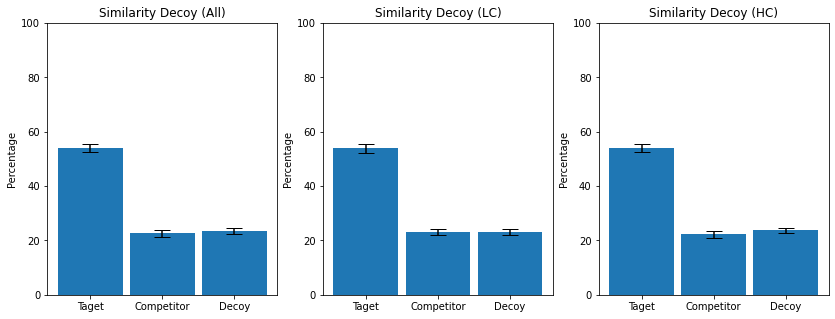

In [27]:
sim_decoy_mean_perc = np.array([target_S_mean, competitor_S_mean, decoy_S_mean])
sim_decoy_sems = np.array([target_S_sem, competitor_S_sem, decoy_S_sem])

sim_decoy_mean_perc_LC = np.array([target_S_LowC_mean, competitor_S_LowC_mean, decoy_S_LowC_mean])
sim_decoy_sems_LC = np.array([target_S_LowC_sem, competitor_S_LowC_sem, decoy_S_LowC_sem])

sim_decoy_mean_perc_HC = np.array([target_S_HighC_mean, competitor_S_HighC_mean, decoy_S_HighC_mean])
sim_decoy_sems_HC = np.array([target_S_HighC_sem, competitor_S_HighC_sem, decoy_S_HighC_sem])

barGraphDecoys3(sim_decoy_mean_perc, sim_decoy_sems, 'Similarity Decoy (All)', sim_decoy_mean_perc_LC, sim_decoy_sems_LC, 'Similarity Decoy (LC)', sim_decoy_mean_perc_HC, sim_decoy_sems_HC, 'Similarity Decoy (HC)')


In [28]:
#sim_decoy_mean_perc_HD = np.array([target_S_HD_mean, competitor_S_HD_mean, decoy_S_HD_mean])
#sim_decoy_sems_HD = np.array([target_S_HD_sem, competitor_S_HD_sem, decoy_S_HD_sem])

#sim_decoy_mean_perc_WD = np.array([target_S_WD_mean, competitor_S_WD_mean, decoy_S_WD_mean])
#sim_decoy_sems_WD = np.array([target_S_WD_sem, competitor_S_WD_sem, decoy_S_WD_sem])

#sim_decoy_mean_perc_U = np.array([target_S_U_mean, competitor_S_U_mean, decoy_S_U_mean])
#sim_decoy_sems_U = np.array([target_S_U_sem, competitor_S_U_sem, decoy_S_U_sem])

#barGraphDecoys3(sim_decoy_mean_perc_HD, sim_decoy_sems_HD, 'Similarity Decoy (HD)', sim_decoy_mean_perc_WD, sim_decoy_sems_WD, 'Similarity Decoy (WD)', sim_decoy_mean_perc_U, sim_decoy_sems_U, 'Similarity Decoy (U)')

### Stat Analysis (Similarity Decoy)

In [29]:
#Check if the two samples have the same variance.
stat_sim_coup, p_sim_coup = stats.levene(group_sim_freq_df_LowC["Target(%)"], group_sim_freq_df_HighC["Target(%)"])

print("p_sim_coup: " + str(p_sim_coup))
    
#Perform two sample t-test with equal variances
Sim_ttest_results = ttest_ind(group_sim_freq_df_LowC["Target(%)"], group_sim_freq_df_HighC["Target(%)"], alternative="two-sided", usevar="pooled")

print("SimDecoy High & Low Coupling: " + "\n t-stat: " + str(round(Sim_ttest_results[0], 3)) + "\n p-value: " + str(round(Sim_ttest_results[1], 3)) + "\n df: " + str(round(Sim_ttest_results[2], 3)))


p_sim_coup: 0.6080650732806911
SimDecoy High & Low Coupling: 
 t-stat: -0.049
 p-value: 0.961
 df: 123.0


In [30]:
# One-way ANOVA w/ statsmodels
SimDecoy_PhanC_lm = ols('Target_perc ~ PhantomCondition', data=group_sim_freq_with_condition_df).fit()

SimDecoy_PhanC_table = sm.stats.anova_lm(SimDecoy_PhanC_lm)

print(SimDecoy_PhanC_table)

                     df        sum_sq     mean_sq         F    PR(>F)
PhantomCondition    2.0    289.136350  144.568175  0.468896  0.626815
Residual          122.0  37614.537119  308.315878       NaN       NaN


## Compromise Decoy

In [31]:
decoy_C_df = all_responses[all_responses["Decoy"] == "C"]

# Filter out biased items.
compromise_biased_items = ["Mobility scooter", "Smart lock"]
decoy_C_df = decoy_C_df[~decoy_C_df.Item.isin(compromise_biased_items) == True]
# Removing items makes compromise effect stronger.

decoy_C_df_LowC = decoy_C_df[decoy_C_df["CouplingCondition"] == "Low coupling"]
decoy_C_df_HighC = decoy_C_df[decoy_C_df["CouplingCondition"] == "High coupling"]
decoy_C_HD_df = decoy_C_df[decoy_C_df["PhantomCondition"] == "Highly_desirable"]
decoy_C_WD_df = decoy_C_df[decoy_C_df["PhantomCondition"] == "Weakly_desirable"]
decoy_C_U_df = decoy_C_df[decoy_C_df["PhantomCondition"] == "Undesirable"]

decoy_C_df = decoy_C_df.reset_index()
decoy_C_df_LowC = decoy_C_df_LowC.reset_index()
decoy_C_df_HighC = decoy_C_df_HighC.reset_index()
decoy_C_HD_df = decoy_C_HD_df.reset_index()
decoy_C_WD_df = decoy_C_WD_df.reset_index()
decoy_C_U_df = decoy_C_U_df.reset_index()

group_com_freq_df = partFreq_Decoy(decoy_C_df, "Com_Decoy")
group_com_freq_with_condition_df = partFreq_DecoyWCondition(decoy_C_df, "Com_Decoy")
group_com_freq_df_LowC = partFreq_Decoy(decoy_C_df_LowC, "Com_Decoy")
group_com_freq_df_HighC = partFreq_Decoy(decoy_C_df_HighC, "Com_Decoy")
group_com_freq_HD_df = partFreq_Decoy(decoy_C_HD_df, "Com_Decoy")
group_com_freq_WD_df = partFreq_Decoy(decoy_C_WD_df, "Com_Decoy")
group_com_freq_U_df = partFreq_Decoy(decoy_C_U_df, "Com_Decoy")

# Get mean, std, and sem for all participatns.
target_C_mean, target_C_std, target_C_sem = get_decoy_stats(group_com_freq_df, "Target(%)", total_n)
competitor_C_mean, competitor_C_std, competitor_C_sem = get_decoy_stats(group_com_freq_df, "Competitor(%)", total_n)
decoy_C_mean, decoy_C_std, decoy_C_sem = get_decoy_stats(group_com_freq_df, "Com_Decoy(%)", total_n)

# Get mean, std, and sem for 'Low coupling' participatns.
target_C_LowC_mean, target_C_LowC_std, target_C_LowC_sem = get_decoy_stats(group_com_freq_df_LowC, "Target(%)", number_of_low_coupling)
competitor_C_LowC_mean, competitor_C_LowC_std, competitor_C_LowC_sem = get_decoy_stats(group_com_freq_df_LowC, "Competitor(%)", number_of_low_coupling)
decoy_C_LowC_mean, decoy_C_LowC_std, decoy_C_LowC_sem = get_decoy_stats(group_com_freq_df_LowC, "Com_Decoy(%)", number_of_low_coupling)

# Get mean, std, and sem for 'High coupling' participatns.
target_C_HighC_mean, target_C_HighC_std, target_C_HighC_sem = get_decoy_stats(group_com_freq_df_HighC, "Target(%)", number_of_high_coupling)
competitor_C_HighC_mean, competitor_C_HighC_std, competitor_C_HighC_sem = get_decoy_stats(group_com_freq_df_HighC, "Competitor(%)", number_of_high_coupling)
decoy_C_HighC_mean, decoy_C_HighC_std, decoy_C_HighC_sem = get_decoy_stats(group_com_freq_df_HighC, "Com_Decoy(%)", number_of_high_coupling)

# Get mean, std, and sem for 'Highly desirable' participatns.
target_C_HD_mean, target_C_HD_std, target_C_HD_sem = get_decoy_stats(group_com_freq_HD_df, "Target(%)", number_of_HD)
competitor_C_HD_mean, competitor_C_HD_std, competitor_C_HD_sem = get_decoy_stats(group_com_freq_HD_df, "Competitor(%)", number_of_HD)
decoy_C_HD_mean, decoy_C_HD_std, decoy_C_HD_sem = get_decoy_stats(group_com_freq_HD_df, "Com_Decoy(%)", number_of_HD)

# Get mean, std, and sem for 'Weakly desirable' participatns.
target_C_WD_mean, target_C_WD_std, target_C_WD_sem = get_decoy_stats(group_com_freq_WD_df, "Target(%)", number_of_WD)
competitor_C_WD_mean, competitor_C_WD_std, competitor_C_WD_sem = get_decoy_stats(group_com_freq_WD_df, "Competitor(%)", number_of_WD)
decoy_C_WD_mean, decoy_C_WD_std, decoy_C_WD_sem = get_decoy_stats(group_com_freq_WD_df, "Com_Decoy(%)", number_of_WD)

# Get mean, std, and sem for 'Undesirable' participatns.
target_C_U_mean, target_C_U_std, target_C_U_sem = get_decoy_stats(group_com_freq_U_df, "Target(%)", number_of_U)
competitor_C_U_mean, competitor_C_U_std, competitor_C_U_sem = get_decoy_stats(group_com_freq_U_df, "Competitor(%)", number_of_U)
decoy_C_U_mean, decoy_C_U_std, decoy_C_U_sem = get_decoy_stats(group_com_freq_U_df, "Com_Decoy(%)", number_of_U)

# Show info for all groups.
Com_summary_df = pd.DataFrame({'Target mean(%)': [target_C_mean, target_C_LowC_mean, target_C_HighC_mean, target_C_HD_mean, target_C_WD_mean, target_C_U_mean],
                  'Target sem(%)': [target_C_sem, target_C_LowC_sem, target_C_HighC_sem, target_C_HD_sem, target_C_WD_sem, target_C_U_sem],
                  'Comp mean(%)': [competitor_C_mean, competitor_C_LowC_mean, competitor_C_HighC_mean, competitor_C_HD_mean, competitor_C_WD_mean, competitor_C_U_mean],
                  'Comp sem(%)': [competitor_C_sem, competitor_C_LowC_sem, competitor_C_HighC_sem, competitor_C_HD_sem, competitor_C_WD_sem, competitor_C_U_sem],
                  'Decoy mean(%)': [decoy_C_mean, decoy_C_LowC_mean, decoy_C_HighC_mean, decoy_C_HD_mean, decoy_C_WD_mean, decoy_C_U_mean],
                  'Decoy sem(%)': [decoy_C_sem, decoy_C_LowC_sem, decoy_C_HighC_sem, decoy_C_HD_sem, decoy_C_WD_sem, decoy_C_U_sem]},
                  index=["All", "LowCoupling", "HighCoupling", "HighlyDesirable", "WeaklyDesirable", "Undesirable"])

Com_summary_df.head(6)

,Target mean(%),Target sem(%),Comp mean(%),Comp sem(%),Decoy mean(%),Decoy sem(%)
All,66.40,1.60,22.60,1.08,11.00,0.85
LowCoupling,67.62,1.47,21.21,0.95,11.17,0.87
HighCoupling,65.23,1.59,23.93,1.10,10.84,0.77
HighlyDesirable,67.34,2.40,22.19,1.78,10.47,1.27
WeaklyDesirable,67.26,2.78,22.55,1.99,10.19,1.35
Undesirable,64.42,3.13,23.08,1.82,12.50,1.81


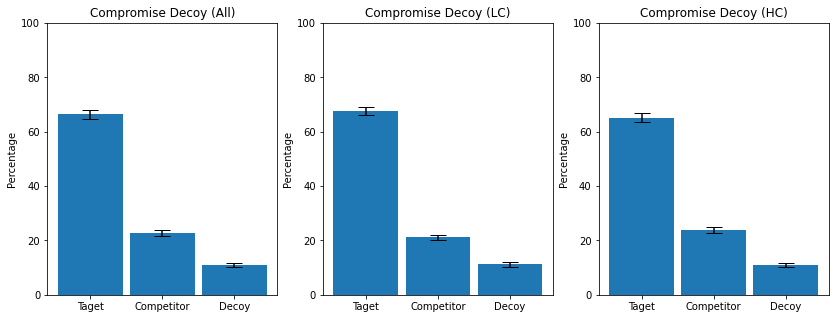

In [32]:
com_decoy_mean_perc = np.array([target_C_mean, competitor_C_mean, decoy_C_mean])
com_decoy_sems = np.array([target_C_sem, competitor_C_sem, decoy_C_sem])

com_decoy_mean_perc_LC = np.array([target_C_LowC_mean, competitor_C_LowC_mean, decoy_C_LowC_mean])
com_decoy_sems_LC = np.array([target_C_LowC_sem, competitor_C_LowC_sem, decoy_C_LowC_sem])

com_decoy_mean_perc_HC = np.array([target_C_HighC_mean, competitor_C_HighC_mean, decoy_C_HighC_mean])
com_decoy_sems_HC = np.array([target_C_HighC_sem, competitor_C_HighC_sem, decoy_C_HighC_sem])

barGraphDecoys3(com_decoy_mean_perc, com_decoy_sems, 'Compromise Decoy (All)', com_decoy_mean_perc_LC, com_decoy_sems_LC, 'Compromise Decoy (LC)', com_decoy_mean_perc_HC, com_decoy_sems_HC, 'Compromise Decoy (HC)')


In [33]:
#com_decoy_mean_perc_HD = np.array([target_C_HD_mean, competitor_C_HD_mean, decoy_C_HD_mean])
#com_decoy_sems_HD = np.array([target_C_HD_sem, competitor_C_HD_sem, decoy_C_HD_sem])

#com_decoy_mean_perc_WD = np.array([target_C_WD_mean, competitor_C_WD_mean, decoy_C_WD_mean])
#com_decoy_sems_WD = np.array([target_C_WD_sem, competitor_C_WD_sem, decoy_C_WD_sem])

#com_decoy_mean_perc_U = np.array([target_C_U_mean, competitor_C_U_mean, decoy_C_U_mean])
#com_decoy_sems_U = np.array([target_C_U_sem, competitor_C_U_sem, decoy_C_U_sem])

#barGraphDecoys3(com_decoy_mean_perc_HD, com_decoy_sems_HD, 'Compromise Decoy (HD)', com_decoy_mean_perc_WD, com_decoy_sems_WD, 'Compromise Decoy (WD)', com_decoy_mean_perc_U, com_decoy_sems_U, 'Compromise Decoy (U)')


### Stat Analysis (Compromise Decoy)

In [34]:
#Check if the two samples have the same variance.
stat_com_coup, p_com_coup = stats.levene(group_com_freq_df_LowC["Target(%)"], group_com_freq_df_HighC["Target(%)"])

print("p_com_coup: " + str(p_com_coup))
    
#Perform two sample t-test with equal variances
Com_ttest_results = ttest_ind(group_com_freq_df_LowC["Target(%)"], group_com_freq_df_HighC["Target(%)"], alternative="two-sided", usevar="pooled")

print("ComDecoy High & Low Coupling: " + "\n t-stat: " + str(round(Com_ttest_results[0], 3)) + "\n p-value: " + str(round(Com_ttest_results[1], 3)) + "\n df: " + str(round(Com_ttest_results[2], 3)))


p_com_coup: 0.2027372448910749
ComDecoy High & Low Coupling: 
 t-stat: 0.744
 p-value: 0.459
 df: 123.0


In [35]:
# One-way ANOVA w/ statsmodels
ComDecoy_PhanC_lm = ols('Target_perc ~ PhantomCondition', data=group_com_freq_with_condition_df).fit()

ComDecoy_PhanC_table = sm.stats.anova_lm(ComDecoy_PhanC_lm)

print(ComDecoy_PhanC_table)

                     df       sum_sq     mean_sq         F   PR(>F)
PhantomCondition    2.0    221.70869  110.854345  0.341557  0.71134
Residual          122.0  39595.79131  324.555666       NaN      NaN


## Attraction Decoy

In [36]:
decoy_A_df = all_responses[all_responses["Decoy"] == "A"]

# Filter out biased items.
attraction_biased_items = ["Car seat", "Leaf Blower", "Rash cream", "Slow cooker", "Tire inflator"]
decoy_A_df = decoy_A_df[~decoy_A_df.Item.isin(attraction_biased_items) == True]
# Filtering out biased items increases a bit attraction effect.

decoy_A_df_LowC = decoy_A_df[decoy_A_df["CouplingCondition"] == "Low coupling"]
decoy_A_df_HighC = decoy_A_df[decoy_A_df["CouplingCondition"] == "High coupling"]
decoy_A_HD_df = decoy_A_df[decoy_A_df["PhantomCondition"] == "Highly_desirable"]
decoy_A_WD_df = decoy_A_df[decoy_A_df["PhantomCondition"] == "Weakly_desirable"]
decoy_A_U_df = decoy_A_df[decoy_A_df["PhantomCondition"] == "Undesirable"]

decoy_A_df = decoy_A_df.reset_index()
decoy_A_df_LowC = decoy_A_df_LowC.reset_index()
decoy_A_df_HighC = decoy_A_df_HighC.reset_index()
decoy_A_HD_df = decoy_A_HD_df.reset_index()
decoy_A_WD_df = decoy_A_WD_df.reset_index()
decoy_A_U_df = decoy_A_U_df.reset_index()

group_att_freq_df = partFreq_Decoy(decoy_A_df, "Att_Decoy")
group_att_freq_with_condition_df = partFreq_DecoyWCondition(decoy_A_df, "Att_Decoy")
group_att_freq_df_LowC = partFreq_Decoy(decoy_A_df_LowC, "Att_Decoy")
group_att_freq_df_HighC = partFreq_Decoy(decoy_A_df_HighC, "Att_Decoy")
group_att_freq_HD_df = partFreq_Decoy(decoy_A_HD_df, "Att_Decoy")
group_att_freq_WD_df = partFreq_Decoy(decoy_A_WD_df, "Att_Decoy")
group_att_freq_U_df = partFreq_Decoy(decoy_A_U_df, "Att_Decoy")

# Get mean, std, and sem for all participatns.
target_A_mean, target_A_std, target_A_sem = get_decoy_stats(group_att_freq_df, "Target(%)", total_n)
competitor_A_mean, competitor_A_std, competitor_A_sem = get_decoy_stats(group_att_freq_df, "Competitor(%)", total_n)
decoy_A_mean, decoy_A_std, decoy_A_sem = get_decoy_stats(group_att_freq_df, "Att_Decoy(%)", total_n)

# Get mean, std, and sem for 'Low coupling' participatns.
target_A_LowC_mean, target_A_LowC_std, target_A_LowC_sem = get_decoy_stats(group_att_freq_df_LowC, "Target(%)", number_of_low_coupling)
competitor_A_LowC_mean, competitor_A_LowC_std, competitor_A_LowC_sem = get_decoy_stats(group_att_freq_df_LowC, "Competitor(%)", number_of_low_coupling)
decoy_A_LowC_mean, decoy_A_LowC_std, decoy_A_LowC_sem = get_decoy_stats(group_att_freq_df_LowC, "Att_Decoy(%)", number_of_low_coupling)

# Get mean, std, and sem for 'High coupling' participatns.
target_A_HighC_mean, target_A_HighC_std, target_A_HighC_sem = get_decoy_stats(group_att_freq_df_HighC, "Target(%)", number_of_high_coupling)
competitor_A_HighC_mean, competitor_A_HighC_std, competitor_A_HighC_sem = get_decoy_stats(group_att_freq_df_HighC, "Competitor(%)", number_of_high_coupling)
decoy_A_HighC_mean, decoy_A_HighC_std, decoy_A_HighC_sem = get_decoy_stats(group_att_freq_df_HighC, "Att_Decoy(%)", number_of_high_coupling)

# Get mean, std, and sem for 'Highly desirable' participatns.
target_A_HD_mean, target_A_HD_std, target_A_HD_sem = get_decoy_stats(group_att_freq_HD_df, "Target(%)", number_of_HD)
competitor_A_HD_mean, competitor_A_HD_std, competitor_A_HD_sem = get_decoy_stats(group_att_freq_HD_df, "Competitor(%)", number_of_HD)
decoy_A_HD_mean, decoy_A_HD_std, decoy_A_HD_sem = get_decoy_stats(group_att_freq_HD_df, "Att_Decoy(%)", number_of_HD)

# Get mean, std, and sem for 'Weakly desirable' participatns.
target_A_WD_mean, target_A_WD_std, target_A_WD_sem = get_decoy_stats(group_att_freq_WD_df, "Target(%)", number_of_WD)
competitor_A_WD_mean, competitor_A_WD_std, competitor_A_WD_sem = get_decoy_stats(group_att_freq_WD_df, "Competitor(%)", number_of_WD)
decoy_A_WD_mean, decoy_A_WD_std, decoy_A_WD_sem = get_decoy_stats(group_att_freq_WD_df, "Att_Decoy(%)", number_of_WD)

# Get mean, std, and sem for 'Undesirable' participatns.
target_A_U_mean, target_A_U_std, target_A_U_sem = get_decoy_stats(group_att_freq_U_df, "Target(%)", number_of_U)
competitor_A_U_mean, competitor_A_U_std, competitor_A_U_sem = get_decoy_stats(group_att_freq_U_df, "Competitor(%)", number_of_U)
decoy_A_U_mean, decoy_A_U_std, decoy_A_U_sem = get_decoy_stats(group_att_freq_U_df, "Att_Decoy(%)", number_of_U)

# Show info for all groups.
Att_summary_df = pd.DataFrame({'Target mean(%)': [target_A_mean, target_A_LowC_mean, target_A_HighC_mean, target_A_HD_mean, target_A_WD_mean, target_A_U_mean],
                  'Target sem(%)': [target_A_sem, target_A_LowC_sem, target_A_HighC_sem, target_A_HD_sem, target_A_WD_sem, target_A_U_sem],
                  'Comp mean(%)': [competitor_A_mean, competitor_A_LowC_mean, competitor_A_HighC_mean, competitor_A_HD_mean, competitor_A_WD_mean, competitor_A_U_mean],
                  'Comp sem(%)': [competitor_A_sem, competitor_A_LowC_sem, competitor_A_HighC_sem, competitor_A_HD_sem, competitor_A_WD_sem, competitor_A_U_sem],
                  'Decoy mean(%)': [decoy_A_mean, decoy_A_LowC_mean, decoy_A_HighC_mean, decoy_A_HD_mean, decoy_A_WD_mean, decoy_A_U_mean],
                  'Decoy sem(%)': [decoy_A_sem, decoy_A_LowC_sem, decoy_A_HighC_sem, decoy_A_HD_sem, decoy_A_WD_sem, decoy_A_U_sem]},
                  index=["All", "LowCoupling", "HighCoupling", "HighlyDesirable", "WeaklyDesirable", "Undesirable"])

Att_summary_df.head(6)

,Target mean(%),Target sem(%),Comp mean(%),Comp sem(%),Decoy mean(%),Decoy sem(%)
All,61.28,1.57,26.88,1.37,11.84,1.19
LowCoupling,60.00,1.68,27.38,1.34,12.62,1.38
HighCoupling,62.50,1.33,26.41,1.30,11.09,0.88
HighlyDesirable,62.75,2.82,25.50,2.40,11.75,1.68
WeaklyDesirable,58.91,2.70,26.52,2.43,14.57,2.50
Undesirable,62.56,2.67,28.72,2.30,8.72,1.65


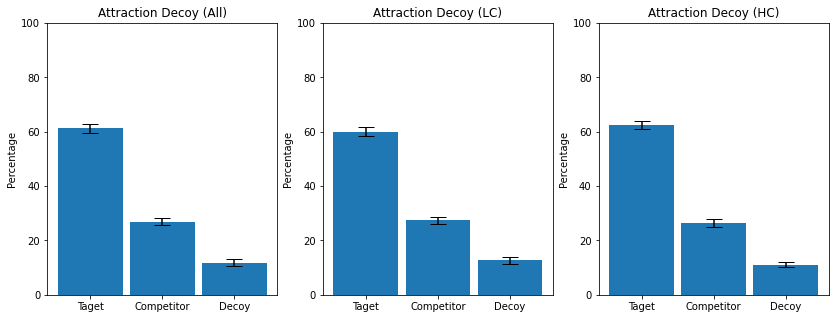

In [37]:
att_decoy_mean_perc = np.array([target_A_mean, competitor_A_mean, decoy_A_mean])
att_decoy_sems = np.array([target_A_sem, competitor_A_sem, decoy_A_sem])

att_decoy_mean_perc_LC = np.array([target_A_LowC_mean, competitor_A_LowC_mean, decoy_A_LowC_mean])
att_decoy_sems_LC = np.array([target_A_LowC_sem, competitor_A_LowC_sem, decoy_A_LowC_sem])

att_decoy_mean_perc_HC = np.array([target_A_HighC_mean, competitor_A_HighC_mean, decoy_A_HighC_mean])
att_decoy_sems_HC = np.array([target_A_HighC_sem, competitor_A_HighC_sem, decoy_A_HighC_sem])

barGraphDecoys3(att_decoy_mean_perc, att_decoy_sems, 'Attraction Decoy (All)', att_decoy_mean_perc_LC, att_decoy_sems_LC, 'Attraction Decoy (LC)', att_decoy_mean_perc_HC, att_decoy_sems_HC, 'Attraction Decoy (HC)')


In [38]:
#att_decoy_mean_perc_HD = np.array([target_A_HD_mean, competitor_A_HD_mean, decoy_A_HD_mean])
#att_decoy_sems_HD = np.array([target_A_HD_sem, competitor_A_HD_sem, decoy_A_HD_sem])

#att_decoy_mean_perc_WD = np.array([target_A_WD_mean, competitor_A_WD_mean, decoy_A_WD_mean])
#att_decoy_sems_WD = np.array([target_A_WD_sem, competitor_A_WD_sem, decoy_A_WD_sem])

#att_decoy_mean_perc_U = np.array([target_A_U_mean, competitor_A_U_mean, decoy_A_U_mean])
#att_decoy_sems_U = np.array([target_A_U_sem, competitor_A_U_sem, decoy_A_U_sem])

#barGraphDecoys3(att_decoy_mean_perc_HD, att_decoy_sems_HD, 'Attraction Decoy (HD)', att_decoy_mean_perc_WD, att_decoy_sems_WD, 'Attraction Decoy (WD)', att_decoy_mean_perc_U, att_decoy_sems_U, 'Attraction Decoy (U)')


### Stat Analysis (Attraction Decoy)

In [39]:
#Check if the two samples have the same variance.
stat_att_coup, p_att_coup = stats.levene(group_att_freq_df_LowC["Target(%)"], group_att_freq_df_HighC["Target(%)"])

print("p_att_coup: " + str(round(p_att_coup, 3)))
    
#Perform two sample t-test with equal variances
Att_ttest_results = ttest_ind(group_att_freq_df_LowC["Target(%)"], group_att_freq_df_HighC["Target(%)"], alternative="two-sided", usevar="pooled")

print("AttDecoy High & Low Coupling: " + "\n t-stat: " + str(round(Att_ttest_results[0], 3)) + "\n p-value: " + str(round(Att_ttest_results[1], 3)) + "\n df: " + str(round(Att_ttest_results[2], 3)))


p_att_coup: 0.529
AttDecoy High & Low Coupling: 
 t-stat: -0.793
 p-value: 0.429
 df: 123.0


In [40]:
# One-way ANOVA w/ statsmodels
AttDecoy_PhanC_lm = ols('Target_perc ~ PhantomCondition', data=group_att_freq_with_condition_df).fit()

AttDecoy_PhanC_table = sm.stats.anova_lm(AttDecoy_PhanC_lm)

print(AttDecoy_PhanC_table)

                     df        sum_sq     mean_sq         F    PR(>F)
PhantomCondition    2.0    408.458082  204.229041  0.655912  0.520789
Residual          122.0  37986.741918  311.366737       NaN       NaN


## Correlation between Classic Decoys

In [41]:
similarity_scores_all = []
compromise_Scores_all = []
attention_scores_all = []

for x in Participants_PIDs: 
    
    similarity_scrore = group_sim_freq_df[group_sim_freq_df["PID"] == x]["Competitor(%)"]/(group_sim_freq_df[group_sim_freq_df["PID"] == x]["Competitor(%)"] + group_sim_freq_df[group_sim_freq_df["PID"] == x]["Target(%)"])
    
    compromise_score = group_com_freq_df[group_com_freq_df["PID"] == x]["Target(%)"]/(group_com_freq_df[group_com_freq_df["PID"] == x]["Target(%)"] + group_com_freq_df[group_com_freq_df["PID"] == x]["Competitor(%)"])
    
    attention_score = group_att_freq_df[group_att_freq_df["PID"] == x]["Target(%)"]/(group_att_freq_df[group_att_freq_df["PID"] == x]["Target(%)"] + group_att_freq_df[group_att_freq_df["PID"] == x]["Competitor(%)"])
    
    similarity_scores_all.append(similarity_scrore)
    
    compromise_Scores_all.append(compromise_score)
    
    attention_scores_all.append(attention_score)
    
similarity_scores_all = np.array(similarity_scores_all)
compromise_Scores_all = np.array(compromise_Scores_all)
attention_scores_all = np.array(attention_scores_all)

all_classic_decoys_df = pd.DataFrame(data={'Similarity': similarity_scores_all.flatten(),
                  'Compromise': compromise_Scores_all.flatten(),
                  'Attraction': attention_scores_all.flatten()}, index=range(total_n))

all_classic_decoys_df = all_classic_decoys_df.fillna(0)
all_classic_decoys_df.head()


,Similarity,Compromise,Attraction
0,0.000000,0.928571,0.777778
1,0.400000,0.466667,0.444444
2,0.181818,0.692308,0.600000
3,0.230769,0.785714,0.625000
4,0.363636,0.937500,0.700000


In [42]:
import scipy.stats as stats

corr_sim_com = stats.pearsonr(all_classic_decoys_df["Similarity"], all_classic_decoys_df["Compromise"])
corr_sim_att = stats.pearsonr(all_classic_decoys_df["Similarity"], all_classic_decoys_df["Attraction"])
corr_att_com = stats.pearsonr(all_classic_decoys_df["Attraction"], all_classic_decoys_df["Compromise"])

print("Correlation coefficient similarity-compromise: " + str(round(corr_sim_com[0], 2)) + ", p-value: " + str(corr_sim_com[1]))
print("Correlation coefficient similarity-attraction: " + str(round(corr_sim_att[0], 2)) + ", p-value: " + str(corr_sim_att[1]))
print("Correlation coefficient attraction-compromise: " + str(round(corr_att_com[0], 2)) + ", p-value: " + str(corr_att_com[1]))


Correlation coefficient similarity-compromise: -0.49, p-value: 6.710526483419168e-09
Correlation coefficient similarity-attraction: -0.38, p-value: 1.1295298572157684e-05
Correlation coefficient attraction-compromise: 0.41, p-value: 1.5794851937437951e-06


Text(0.5, 1.0, 'Compromise vs. Attraction')

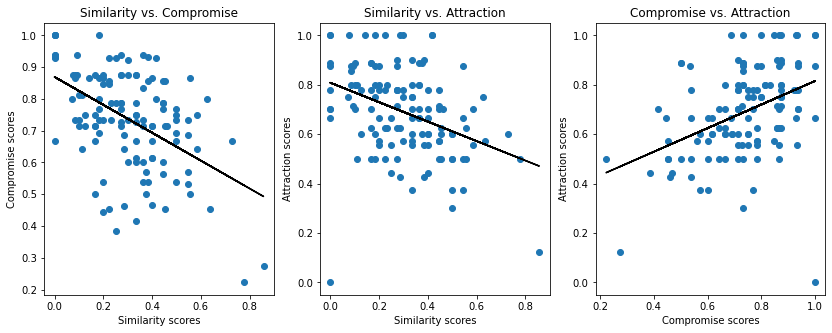

In [43]:
fig, ax = plt.subplots(1, 3, figsize=(14, 5))

ax[0].scatter(all_classic_decoys_df["Similarity"], all_classic_decoys_df["Compromise"])
a_0, b_0 = np.polyfit(np.array(all_classic_decoys_df["Similarity"]).flatten(), np.array(all_classic_decoys_df["Compromise"]).flatten(), 1)
ax[0].plot(all_classic_decoys_df["Similarity"], a_0*all_classic_decoys_df["Similarity"]+b_0, color='black')  
ax[0].set_xlabel("Similarity scores")
ax[0].set_ylabel("Compromise scores")
ax[0].set_title("Similarity vs. Compromise")

ax[1].scatter(all_classic_decoys_df["Similarity"], all_classic_decoys_df["Attraction"])
a_1, b_1 = np.polyfit(np.array(all_classic_decoys_df["Similarity"]).flatten(), np.array(all_classic_decoys_df["Attraction"]).flatten(), 1)
ax[1].plot(all_classic_decoys_df["Similarity"], a_1*all_classic_decoys_df["Similarity"]+b_1, color='black')  
ax[1].set_xlabel("Similarity scores")
ax[1].set_ylabel("Attraction scores")
ax[1].set_title("Similarity vs. Attraction")

ax[2].scatter(all_classic_decoys_df["Compromise"], all_classic_decoys_df["Attraction"])
a_2, b_2 = np.polyfit(np.array(all_classic_decoys_df["Compromise"]).flatten(), np.array(all_classic_decoys_df["Attraction"]).flatten(), 1)
ax[2].plot(all_classic_decoys_df["Compromise"], a_2*all_classic_decoys_df["Compromise"]+b_2, color='black')  
ax[2].set_xlabel("Compromise scores")
ax[2].set_ylabel("Attraction scores")
ax[2].set_title("Compromise vs. Attraction")


## Mediation Analysis on Classical Decoys

### Mediation Analysis (Attraction -> Compromise; M=Similarity)

In [151]:
# Does Similarity mediate the relationship between Attraction-Compromise?

mediation_analysis(data=all_classic_decoys_df, x='Attraction', m='Similarity', y='Compromise', 
                   alpha=0.05, n_boot=100)


,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,Similarity ~ X,-0.369963,0.080805,1.129530e-05,-0.529911,-0.210015,Yes
1,Y ~ Similarity,-0.438731,0.070402,6.710526e-09,-0.578088,-0.299375,Yes
2,Total,0.359596,0.071265,1.579485e-06,0.218532,0.500661,Yes
3,Direct,0.230904,0.071138,1.511817e-03,0.090079,0.371730,Yes
4,Indirect,0.128692,0.052388,0.000000e+00,0.053906,0.291436,Yes


### Mediation Analysis (Attraction -> Similarity; M=Compromise)


In [153]:
mediation_analysis(data=all_classic_decoys_df, x='Attraction', m='Compromise', y='Similarity', 
                   alpha=0.05, n_boot=100)

,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,Compromise ~ X,0.359596,0.071265,1.579485e-06,0.218532,0.500661,Yes
1,Y ~ Compromise,-0.546961,0.087769,6.710526e-09,-0.720695,-0.373228,Yes
2,Total,-0.369963,0.080805,1.129530e-05,-0.529911,-0.210015,Yes
3,Direct,-0.209146,0.081912,1.190274e-02,-0.371299,-0.046994,Yes
4,Indirect,-0.160817,0.054484,0.000000e+00,-0.287598,-0.074701,Yes


### Mediation Analysis (Similarity -> Compromise; M=Attraction)


In [46]:
mediation_analysis(data=all_classic_decoys_df, x='Similarity', m='Attraction', y='Compromise', 
                   alpha=0.05, n_boot=100)

,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,Attraction ~ X,-0.393582,0.085963,1.129530e-05,-0.563741,-0.223423,Yes
1,Y ~ Attraction,0.359596,0.071265,1.579485e-06,0.218532,0.500661,Yes
2,Total,-0.438731,0.070402,6.710526e-09,-0.578088,-0.299375,Yes
3,Direct,-0.347852,0.073374,5.823384e-06,-0.493103,-0.202600,Yes
4,Indirect,-0.090880,0.054113,0.000000e+00,-0.192777,-0.008728,Yes


### Mediation Analysis (Similarity -> Attraction; M=Compromise)


In [47]:
mediation_analysis(data=all_classic_decoys_df, x='Similarity', m='Compromise', y='Attraction', 
                   alpha=0.05, n_boot=100)

,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,Compromise ~ X,-0.438731,0.070402,6.710526e-09,-0.578088,-0.299375,Yes
1,Y ~ Compromise,0.476925,0.094517,1.579485e-06,0.289834,0.664016,Yes
2,Total,-0.393582,0.085963,1.129530e-05,-0.563741,-0.223423,Yes
3,Direct,-0.242543,0.094991,1.190274e-02,-0.430588,-0.054497,Yes
4,Indirect,-0.151039,0.057369,0.000000e+00,-0.286535,-0.048918,Yes


### Mediation Analysis (Compromise -> Attraction; M=Similarity)


In [48]:
mediation_analysis(data=all_classic_decoys_df, x='Compromise', m='Similarity', y='Attraction', 
                   alpha=0.05, n_boot=100)

,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,Similarity ~ X,-0.546961,0.087769,6.710526e-09,-0.720695,-0.373228,Yes
1,Y ~ Similarity,-0.393582,0.085963,1.129530e-05,-0.563741,-0.223423,Yes
2,Total,0.476925,0.094517,1.579485e-06,0.289834,0.664016,Yes
3,Direct,0.344264,0.106063,1.511817e-03,0.134302,0.554226,Yes
4,Indirect,0.132661,0.059078,0.000000e+00,0.018940,0.260152,Yes


### Mediation Analysis (Compromise -> Similarity; M=Attraction)


In [49]:
mediation_analysis(data=all_classic_decoys_df, x='Compromise', m='Attraction', y='Similarity', 
                   alpha=0.05, n_boot=100)

,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,Attraction ~ X,0.476925,0.094517,1.579485e-06,0.289834,0.664016,Yes
1,Y ~ Attraction,-0.369963,0.080805,1.129530e-05,-0.529911,-0.210015,Yes
2,Total,-0.546961,0.087769,6.710526e-09,-0.720695,-0.373228,Yes
3,Direct,-0.447214,0.094333,5.823384e-06,-0.633956,-0.260473,Yes
4,Indirect,-0.099747,0.060772,4.000000e-02,-0.225249,-0.007954,Yes


## PCA Analysis on Classical Decoys

In [50]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

principalComponents = pca.fit_transform(all_classic_decoys_df)

pca.explained_variance_ratio_

array([0.61862228, 0.22723892])

In [51]:
pca.components_

array([[ 0.60252063, -0.51315567, -0.61126111],
       [-0.59823747,  0.2165733 , -0.7714972 ]])

In [52]:
all_classic_decoys_df.head()

,Similarity,Compromise,Attraction
0,0.000000,0.928571,0.777778
1,0.400000,0.466667,0.444444
2,0.181818,0.692308,0.600000
3,0.230769,0.785714,0.625000
4,0.363636,0.937500,0.700000


In [53]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=2, n_iter=5)

svd.fit(all_classic_decoys_df)

svd.explained_variance_ratio_


array([0.34088199, 0.46455546])

## Phantom Decoys

### Highly Desirable Group

In [54]:
# Phantom Decoy: Highly Desirable
decoy_P_df = all_responses[all_responses["Decoy"] == "P"]

decoy_P_HD_df = decoy_P_df[decoy_P_df["PhantomCondition"] == "Highly_desirable"]
decoy_P_HD_df_LowC = decoy_P_HD_df[decoy_P_HD_df["CouplingCondition"] == "Low coupling"]
decoy_P_HD_df_HighC = decoy_P_HD_df[decoy_P_HD_df["CouplingCondition"] == "High coupling"]

decoy_P_HD_df = decoy_P_HD_df.reset_index()
decoy_P_HD_df_LowC = decoy_P_HD_df_LowC.reset_index()
decoy_P_HD_df_HighC = decoy_P_HD_df_HighC.reset_index()

total_n = decoy_P_HD_df["Survey_ID"].unique()
number_of_low_coupling = decoy_P_HD_df_LowC["Survey_ID"].unique()
number_of_high_coupling = decoy_P_HD_df_HighC["Survey_ID"].unique()

total_n = int(len(total_n))
number_of_low_coupling = int(len(number_of_low_coupling))
number_of_high_coupling = int(len(number_of_high_coupling))

decoy_P_HD_freq_df = partFreq_PhantomDecoy(decoy_P_HD_df)
decoy_P_HD_LowC_freq_df = partFreq_PhantomDecoy(decoy_P_HD_df_LowC)
decoy_P_HD_HighC_freq_df = partFreq_PhantomDecoy(decoy_P_HD_df_HighC)

# Get mean, std, and sem for all participatns.
target_P_HD_mean, target_P_HD_std, target_P_HD_sem = get_decoy_stats(decoy_P_HD_freq_df, "Target(%)", total_n)
competitor_P_HD_mean, competitor_P_HD_std, competitor_P_HD_sem = get_decoy_stats(decoy_P_HD_freq_df, "Competitor(%)", total_n)

# Get mean, std, and sem for 'Low coupling' participatns.
target_P_HD_LowC_mean, target_P_HD_LowC_std, target_P_HD_LowC_sem = get_decoy_stats(decoy_P_HD_LowC_freq_df, "Target(%)", number_of_low_coupling)
competitor_P_HD_LowC_mean, competitor_P_HD_LowC_std, competitor_P_HD_LowC_sem = get_decoy_stats(decoy_P_HD_LowC_freq_df, "Competitor(%)", number_of_low_coupling)

# Get mean, std, and sem for 'High coupling' participatns.
target_P_HD_HighC_mean, target_P_HD_HighC_std, target_P_HD_HighC_sem = get_decoy_stats(decoy_P_HD_HighC_freq_df, "Target(%)", number_of_high_coupling)
competitor_P_HD_HighC_mean, competitor_P_HD_HighC_std, competitor_P_HD_HighC_sem = get_decoy_stats(decoy_P_HD_HighC_freq_df, "Competitor(%)", number_of_high_coupling)

P_HD_summary_df = pd.DataFrame({'Target mean(%)': [target_P_HD_mean, target_P_HD_LowC_mean, target_P_HD_HighC_mean],
                  'Target sem(%)': [target_P_HD_sem, target_P_HD_LowC_sem, target_P_HD_HighC_sem],
                  'Comp mean(%)': [competitor_P_HD_mean, competitor_P_HD_LowC_mean, competitor_P_HD_HighC_mean],
                  'Comp sem(%)': [competitor_P_HD_sem, competitor_P_HD_LowC_sem, competitor_P_HD_HighC_sem]},
                  index=["All", "LowCoupling", "HighCoupling"])

P_HD_summary_df.head()

,Target mean(%),Target sem(%),Comp mean(%),Comp sem(%)
All,58.12,1.64,41.88,1.64
LowCoupling,57.89,2.40,42.11,2.40
HighCoupling,58.33,2.30,41.67,2.30


In [269]:
target_P_HD_std

10.358169078880044

### Weakly Desirable Group

In [55]:
# Phantom Decoy: Weakly Desirable
decoy_P_WD_df = decoy_P_df[decoy_P_df["PhantomCondition"] == "Weakly_desirable"]
decoy_P_WD_df_LowC = decoy_P_WD_df[decoy_P_WD_df["CouplingCondition"] == "Low coupling"]
decoy_P_WD_df_HighC = decoy_P_WD_df[decoy_P_WD_df["CouplingCondition"] == "High coupling"]

decoy_P_WD_df = decoy_P_WD_df.reset_index()
decoy_P_WD_df_LowC = decoy_P_WD_df_LowC.reset_index()
decoy_P_WD_df_HighC = decoy_P_WD_df_HighC.reset_index()

total_n = decoy_P_WD_df["Survey_ID"].unique()
number_of_low_coupling = decoy_P_WD_df_LowC["Survey_ID"].unique()
number_of_high_coupling = decoy_P_WD_df_HighC["Survey_ID"].unique()

total_n = int(len(total_n))
number_of_low_coupling = int(len(number_of_low_coupling))
number_of_high_coupling = int(len(number_of_high_coupling))

decoy_P_WD_freq_df = partFreq_PhantomDecoy(decoy_P_WD_df)
decoy_P_WD_LowC_freq_df = partFreq_PhantomDecoy(decoy_P_WD_df_LowC)
decoy_P_WD_HighC_freq_df = partFreq_PhantomDecoy(decoy_P_WD_df_HighC)

# Get mean, std, and sem for all participatns.
target_P_WD_mean, target_P_WD_std, target_P_WD_sem = get_decoy_stats(decoy_P_WD_freq_df, "Target(%)", total_n)
competitor_P_WD_mean, competitor_P_WD_std, competitor_P_WD_sem = get_decoy_stats(decoy_P_WD_freq_df, "Competitor(%)", total_n)

# Get mean, std, and sem for 'Low coupling' participatns.
target_P_WD_LowC_mean, target_P_WD_LowC_std, target_P_WD_LowC_sem = get_decoy_stats(decoy_P_WD_LowC_freq_df, "Target(%)", number_of_low_coupling)
competitor_P_WD_LowC_mean, competitor_P_WD_LowC_std, competitor_P_WD_LowC_sem = get_decoy_stats(decoy_P_WD_LowC_freq_df, "Competitor(%)", number_of_low_coupling)

# Get mean, std, and sem for 'High coupling' participatns.
target_P_WD_HighC_mean, target_P_WD_HighC_std, target_P_WD_HighC_sem = get_decoy_stats(decoy_P_WD_HighC_freq_df, "Target(%)", number_of_high_coupling)
competitor_P_WD_HighC_mean, competitor_P_WD_HighC_std, competitor_P_WD_HighC_sem = get_decoy_stats(decoy_P_WD_HighC_freq_df, "Competitor(%)", number_of_high_coupling)

P_WD_summary_df = pd.DataFrame({'Target mean(%)': [target_P_WD_mean, target_P_WD_LowC_mean, target_P_WD_HighC_mean],
                  'Target sem(%)': [target_P_WD_sem, target_P_WD_LowC_sem, target_P_WD_HighC_sem],
                  'Comp mean(%)': [competitor_P_WD_mean, competitor_P_WD_LowC_mean, competitor_P_WD_HighC_mean],
                  'Comp sem(%)': [competitor_P_WD_sem, competitor_P_WD_LowC_sem, competitor_P_WD_HighC_sem]},
                  index=["All", "LowCoupling", "HighCoupling"])

P_WD_summary_df.head()

,Target mean(%),Target sem(%),Comp mean(%),Comp sem(%)
All,54.13,1.64,45.87,1.64
LowCoupling,52.78,2.66,47.22,2.66
HighCoupling,55.00,2.11,45.00,2.11


### Undesirable Group

In [56]:
# Phantom Decoy: Undesirable
decoy_P_U_df = decoy_P_df[decoy_P_df["PhantomCondition"] == "Undesirable"]
decoy_P_U_df_LowC = decoy_P_U_df[decoy_P_U_df["CouplingCondition"] == "Low coupling"]
decoy_P_U_df_HighC = decoy_P_U_df[decoy_P_U_df["CouplingCondition"] == "High coupling"]

decoy_P_U_df = decoy_P_U_df.reset_index()
decoy_P_U_df_LowC = decoy_P_U_df_LowC.reset_index()
decoy_P_U_df_HighC = decoy_P_U_df_HighC.reset_index()

total_n = decoy_P_U_df["Survey_ID"].unique()
number_of_low_coupling = decoy_P_U_df_LowC["Survey_ID"].unique()
number_of_high_coupling = decoy_P_U_df_HighC["Survey_ID"].unique()

total_n = int(len(total_n))
number_of_low_coupling = int(len(number_of_low_coupling))
number_of_high_coupling = int(len(number_of_high_coupling))

decoy_P_U_freq_df = partFreq_PhantomDecoy(decoy_P_U_df)
decoy_P_U_LowC_freq_df = partFreq_PhantomDecoy(decoy_P_U_df_LowC)
decoy_P_U_HighC_freq_df = partFreq_PhantomDecoy(decoy_P_U_df_HighC)

# Get mean, std, and sem for all participatns.
target_P_U_mean, target_P_U_std, target_P_U_sem = get_decoy_stats(decoy_P_U_freq_df, "Target(%)", total_n)
competitor_P_U_mean, competitor_P_U_std, competitor_P_U_sem = get_decoy_stats(decoy_P_U_freq_df, "Competitor(%)", total_n)

# Get mean, std, and sem for 'Low coupling' participatns.
target_P_U_LowC_mean, target_P_U_LowC_std, target_P_U_LowC_sem = get_decoy_stats(decoy_P_U_LowC_freq_df, "Target(%)", number_of_low_coupling)
competitor_P_U_LowC_mean, competitor_P_U_LowC_std, competitor_P_U_LowC_sem = get_decoy_stats(decoy_P_U_LowC_freq_df, "Competitor(%)", number_of_low_coupling)

# Get mean, std, and sem for 'High coupling' participatns.
target_P_U_HighC_mean, target_P_U_HighC_std, target_P_U_HighC_sem = get_decoy_stats(decoy_P_U_HighC_freq_df, "Target(%)", number_of_high_coupling)
competitor_P_U_HighC_mean, competitor_P_U_HighC_std, competitor_P_U_HighC_sem = get_decoy_stats(decoy_P_U_HighC_freq_df, "Competitor(%)", number_of_high_coupling)

P_U_summary_df = pd.DataFrame({'Target mean(%)': [target_P_U_mean, target_P_U_LowC_mean, target_P_U_HighC_mean],
                  'Target sem(%)': [target_P_U_sem, target_P_U_LowC_sem, target_P_U_HighC_sem],
                  'Comp mean(%)': [competitor_P_U_mean, competitor_P_U_LowC_mean, competitor_P_U_HighC_mean],
                  'Comp sem(%)': [competitor_P_U_sem, competitor_P_U_LowC_sem, competitor_P_U_HighC_sem]},
                  index=["All", "LowCoupling", "HighCoupling"])

P_U_summary_df.head()

,Target mean(%),Target sem(%),Comp mean(%),Comp sem(%)
All,51.92,1.77,48.08,1.77
LowCoupling,52.71,2.39,47.29,2.39
HighCoupling,50.67,2.62,49.33,2.62


In [268]:
target_P_U_std

11.039128053344506

### Displaying All Phantoms

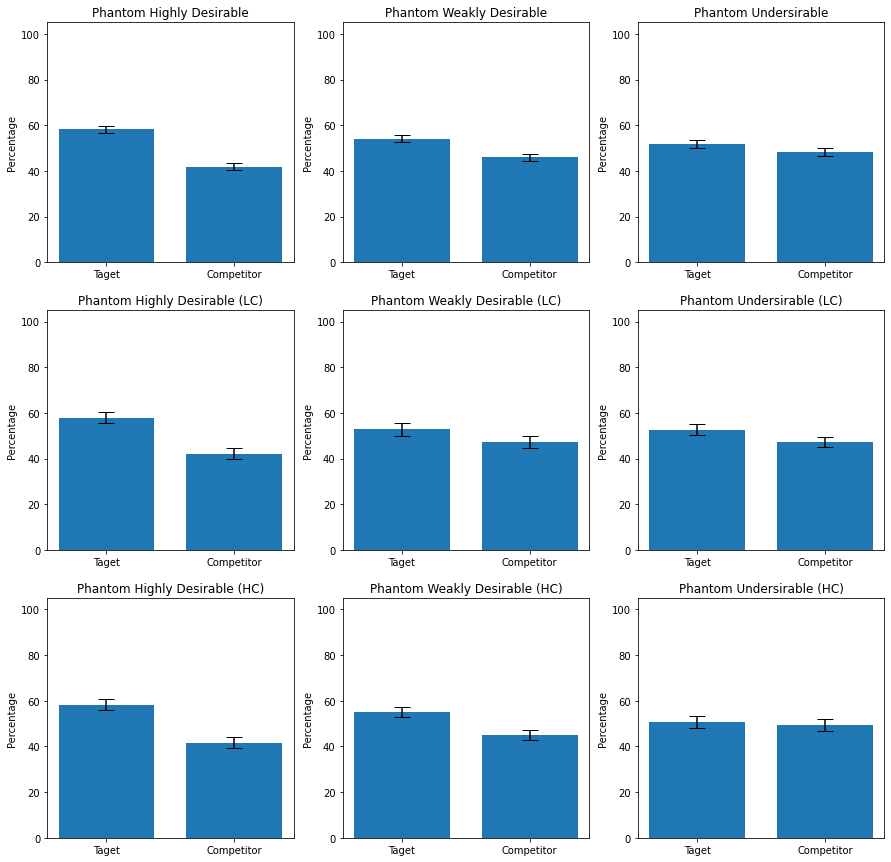

In [57]:
labels = ['Taget', 'Competitor']

x = np.arange(len(labels))

y1 = np.array([target_P_HD_mean, competitor_P_HD_mean])
y2 = np.array([target_P_WD_mean, competitor_P_WD_mean])
y3 = np.array([target_P_U_mean, competitor_P_U_mean])

error1 = np.array([target_P_HD_sem, competitor_P_HD_sem])
error2 = np.array([target_P_WD_sem, competitor_P_WD_sem])
error3 = np.array([target_P_U_sem, competitor_P_U_sem])

y1s = np.array([y1, y2, y3])
errors1 = np.array([error1, error2, error3])

ys = np.array([[[target_P_HD_mean, competitor_P_HD_mean], [target_P_WD_mean, competitor_P_WD_mean], [target_P_U_mean, competitor_P_U_mean]],
              [[target_P_HD_LowC_mean, competitor_P_HD_LowC_mean], [target_P_WD_LowC_mean, competitor_P_WD_LowC_mean], [target_P_U_LowC_mean, competitor_P_U_LowC_mean]], 
              [[target_P_HD_HighC_mean, competitor_P_HD_HighC_mean], [target_P_WD_HighC_mean, competitor_P_WD_HighC_mean], [target_P_U_HighC_mean, competitor_P_U_HighC_mean]]])

errors = np.array([[[target_P_HD_sem, competitor_P_HD_sem], [target_P_WD_sem, competitor_P_WD_sem], [target_P_U_sem, competitor_P_U_sem]],
                  [[target_P_HD_LowC_sem, competitor_P_HD_LowC_sem], [target_P_WD_LowC_sem, competitor_P_WD_LowC_sem], [target_P_U_LowC_sem, competitor_P_U_LowC_sem]],
                  [[target_P_HD_HighC_sem, competitor_P_HD_HighC_sem], [target_P_WD_HighC_sem, competitor_P_WD_HighC_sem], [target_P_U_HighC_sem, competitor_P_U_HighC_sem]]])

titles = [["Phantom Highly Desirable", "Phantom Weakly Desirable", "Phantom Undersirable"],
         ["Phantom Highly Desirable (LC)", "Phantom Weakly Desirable (LC)", "Phantom Undersirable (LC)"],
         ["Phantom Highly Desirable (HC)", "Phantom Weakly Desirable (HC)", "Phantom Undersirable (HC)"]]

fig, ax = plt.subplots(3, 3, figsize=(15, 15))
                       
for x in range(3):
    for y in range(3):
        ax[y][x].bar(labels, ys[y][x], 0.75, yerr=errors[y][x], capsize=8)
        ax[y][x].set_ylim(0, 105)
        ax[y][x].set_ylabel('Percentage')
        ax[y][x].set_title(titles[y][x])
        
plt.show()

Text(0.5, 1.0, 'Noisy Phantoms')

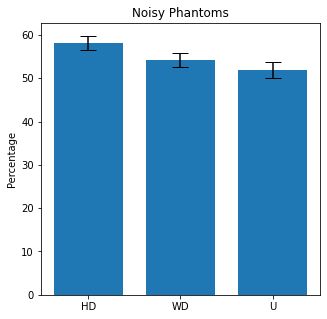

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.bar(['HD', 'WD', "U"], [target_P_HD_mean, target_P_WD_mean, target_P_U_mean], 0.75, capsize=8, yerr=[target_P_HD_sem, target_P_WD_sem, target_P_U_sem])
#error_bars = ax.errorbar(x=['HD', 'WD', "U"], y=[target_P_HD_mean, target_P_WD_mean, target_P_U_mean], yerr=[target_P_HD_sem, target_P_WD_sem, target_P_U_sem])
#ax.set_ylim(40, 65)
#xys = error_bars.lines[0].get_xydata()
#print(xys)

ax.set_ylabel('Percentage')
ax.set_title("Noisy Phantoms")


In [260]:
decoy_P_part_df

,PID,Target(num),Competitor(num),Target(%),Competitor(%),Target_perc,Competitor_perc_,PhantomCondition,CouplingCondition
0,40781,12,8,NaN,NaN,60.0,40.0,Highly_desirable,High coupling
1,40447,12,8,NaN,NaN,60.0,40.0,Highly_desirable,Low coupling
2,41454,10,10,NaN,NaN,50.0,50.0,Undesirable,Low coupling
3,34796,8,12,NaN,NaN,40.0,60.0,Weakly_desirable,Low coupling
4,44066,9,11,NaN,NaN,45.0,55.0,Weakly_desirable,High coupling
...,...,...,...,...,...,...,...,...,...
120,44089,9,11,NaN,NaN,45.0,55.0,Highly_desirable,High coupling
121,31535,8,12,NaN,NaN,40.0,60.0,Highly_desirable,Low coupling
122,37897,11,9,NaN,NaN,55.0,45.0,Weakly_desirable,Low coupling
123,42986,10,10,NaN,NaN,50.0,50.0,Highly_desirable,High coupling


<ErrorbarContainer object of 3 artists>

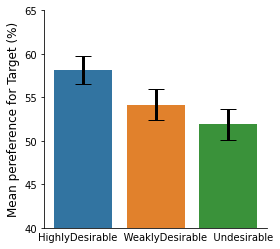

In [265]:
decoy_P_part_df = partFreq_PhantomDecoyWCondition(decoy_P_df)
#decoy_P_part_df['PhantomCondition'] = decoy_P_part_df['PhantomCondition'].replace(['Highly_desirable'],'Highly desirable')
#decoy_P_part_df['PhantomCondition'] = decoy_P_part_df['PhantomCondition'].replace(['Weakly_desirable'],'Weakly desirable')

fig, ax = plt.subplots(1, 1, figsize=(4, 4))

sns_y1 = np.array([target_P_HD_mean, target_P_WD_mean, target_P_U_mean])
sns_x1 = ["Highly_desirable", "Weakly_desirable", "Undesirable"]
sns_error1 = np.array([target_P_HD_sem, target_P_WD_sem, target_P_U_sem])

PNBar = sns.barplot(x="PhantomCondition", y="Target_perc",
            order=["Highly_desirable", "Weakly_desirable", "Undesirable"],
            ci=None,
            ax=ax,        
            data=decoy_P_part_df) #kind="bar", ci=None,
PNBar.set(ylim=(40, 65))

sns.despine()
ax.set_xticks([])
#ax.set_xticks(["Highly desirable", "Weakly desirable", "Undesirable"])

ax.set_ylabel('Mean pereference for Target (%)', size=12)
ax.set_xlabel("HighlyDesirable  WeaklyDesirable  Undesirable", size=10)

bars = PNBar.errorbar(x=sns_x1, y=sns_y1, yerr=sns_error1)

xys = bars.lines[0].get_xydata()
xys2 = np.array([[0, 58.12], [1, 54.13], [2, 51.92]])
xys3 = np.array([[0, 58.12], [1, 0], [2, 0]])
#xys3 = xys[:,0] + np.array()
#print(xys)
bars.remove()
#["Highly_desirable", "Weakly_desirable", "Undesirable"]
PNBar.errorbar(x=xys2[:, 0], y=[target_P_HD_mean, target_P_WD_mean, target_P_U_mean], 
               yerr=[target_P_HD_sem, target_P_WD_sem, target_P_U_sem],
              ls='', lw=3, color='black', capsize=8)






In [69]:
#sns_y1

In [70]:
#sns_error1

3
[[0.  0.4]
 [1.  0.6]
 [2.  0.6]]
-0.2666666666666667
[[0.  0.5]
 [1.  0.7]
 [2.  0.2]]
0.0
[[0.  0.5]
 [1.  0.7]
 [2.  0.4]]
0.2666666666666666


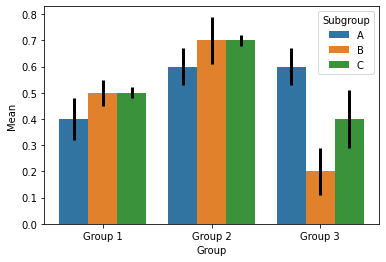

In [71]:
x = pd.DataFrame([
    ['Group 1', 'A', 0.4, 0.08],
    ['Group 1', 'B', 0.5, 0.05],
    ['Group 1', 'C', 0.5, 0.02],
    ['Group 2', 'A', 0.6, 0.07],
    ['Group 2', 'B', 0.7, 0.09],
    ['Group 2', 'C', 0.7, 0.02],
    ['Group 3', 'A', 0.6, 0.07],
    ['Group 3', 'B', 0.2, 0.09],
    ['Group 3', 'C', 0.4, 0.11],
], columns=['Group', 'Subgroup', 'Mean', 'SD'])

num_hues = len(np.unique(x['Subgroup']))
print(num_hues)
ax = sns.barplot(data=x, x='Group', y='Mean', hue='Subgroup')
for (hue, df_hue), dogde_dist in zip(x.groupby('Subgroup'), np.linspace(-0.4, 0.4, 2 * num_hues + 1)[1::2]):
    bars = ax.errorbar(data=df_hue, x='Group', y='Mean', yerr='SD', ls='', lw=3, color='black')
    xys = bars.lines[0].get_xydata()
    bars.remove()
    print(xys)
    print(dogde_dist)
    ax.errorbar(data=df_hue, x=xys[:, 0] + dogde_dist, y='Mean', yerr='SD', ls='', lw=3, color='black')
plt.show()

In [ ]:
# Makes figures comparing all items and not biased items.

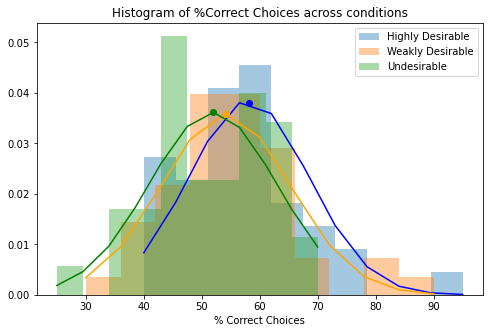

In [72]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

n_HD, bins_HD, patches_HD = ax.hist(decoy_P_HD_freq_df["Target(%)"], density=True, histtype='barstacked', rwidth=None, label="Highly Desirable", alpha=0.4, bins=10)
y_HD = ((1 / (np.sqrt(2 * np.pi) * target_P_HD_std)) * np.exp(-0.5 * (1 / target_P_HD_std * (bins_HD - target_P_HD_mean))**2))
ax.plot(bins_HD, y_HD, color="blue")
ax.plot(target_P_HD_mean, max(y_HD), "ro", color="blue")

n_WD, bins_WD, patches_WD = ax.hist(decoy_P_WD_freq_df["Target(%)"], density=True, histtype='barstacked', rwidth=None, label="Weakly Desirable", alpha=0.4, bins=10)
y_WD = ((1 / (np.sqrt(2 * np.pi) * target_P_WD_std)) * np.exp(-0.5 * (1 / target_P_WD_std * (bins_WD - target_P_WD_mean))**2))
ax.plot(bins_WD, y_WD, color="orange")
ax.plot(target_P_WD_mean, max(y_WD), "ro", color="orange")

n_U, bins_U, patches_U = ax.hist(decoy_P_U_freq_df["Target(%)"], density=True, histtype='barstacked', rwidth=None, label="Undesirable", alpha=0.4, bins=10)
y_U = ((1 / (np.sqrt(2 * np.pi) * target_P_U_std)) * np.exp(-0.5 * (1 / target_P_U_std * (bins_U - target_P_U_mean))**2))
ax.plot(bins_U, y_U, color="green")
ax.plot(target_P_U_mean, max(y_U), "ro", color="green")

ax.set_title("Histogram of %Correct Choices across conditions")
ax.set_xlabel('% Correct Choices')
ax.legend()
plt.show()


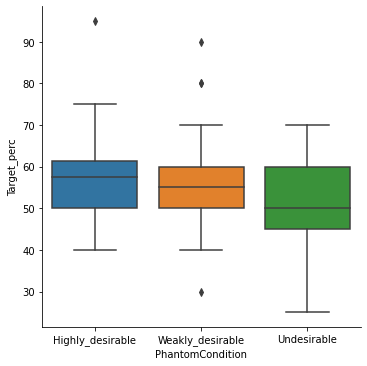

In [73]:

sns.catplot(x="PhantomCondition", y="Target_perc", kind="box", order=["Highly_desirable", "Weakly_desirable", "Undesirable"], data=decoy_P_part_df)

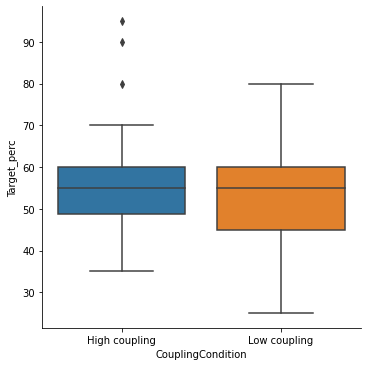

In [74]:
sns.catplot(x="CouplingCondition", y="Target_perc", kind="box", data=decoy_P_part_df)

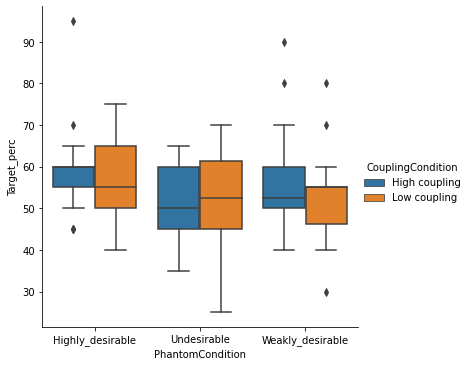

In [75]:
sns.catplot(x="PhantomCondition", y="Target_perc", kind="box", hue="CouplingCondition", data=decoy_P_part_df)


### Statistical Analysis Phantom Decoys NoisyItems

#### All conditions One-way ANOVA

In [76]:
#One-way ANOVA "PhantomCondition" with statsmodels
PhanDecoys_Noisy_lm = ols('Target_perc ~ PhantomCondition', data=decoy_P_part_df).fit()

PhanDecoys_Noisy_table = sm.stats.anova_lm(PhanDecoys_Noisy_lm)

print(PhanDecoys_Noisy_table)

                     df        sum_sq     mean_sq         F    PR(>F)
PhantomCondition    2.0    784.838378  392.419189  3.329203  0.039104
Residual          122.0  14380.361622  117.871817       NaN       NaN


In [267]:
PhanDecoys_Noisy_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Target_perc   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     3.329
Date:                Fri, 03 Jun 2022   Prob (F-statistic):             0.0391
Time:                        01:27:32   Log-Likelihood:                -473.95
No. Observations:                 125   AIC:                             953.9
Df Residuals:                     122   BIC:                             962.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                               58.1250      1.717     33.860      0.000      54.727      61.523
PhantomCondition[T.Undesirable]         -6.2019      2.443     -2.538      0.012     -11.038      -1.365
PhantomCondition[T.Weakly_desirable]    -3.9946      2.347     -1.702      0.091      -8.641       0.652
==============================================================================
Omnibus:                       12.361   Durbin-Watson:                   2.128
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               14.626
Skew:                           0.607   Prob(JB):                     0.000667
Kurtosis:                       4.155   Cond. No.                         3.81
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [77]:
#One-way ANOVA "PhantomCondition" with scipy.stats
f_oneway(decoy_P_HD_freq_df["Target(%)"], decoy_P_WD_freq_df["Target(%)"], decoy_P_U_freq_df["Target(%)"])


F_onewayResult(statistic=3.329202860936702, pvalue=0.03910403517705392)

In [78]:
#One-way ANOVA "CouplingCondition" with statsmodels
PhanDecoys_CoupC_Noisy_lm = ols('Target_perc ~ CouplingCondition', data=decoy_P_part_df).fit()

PhanDecoys_CoupC_Noisy_table = sm.stats.anova_lm(PhanDecoys_CoupC_Noisy_lm)

print(PhanDecoys_CoupC_Noisy_table)

                      df        sum_sq     mean_sq         F    PR(>F)
CouplingCondition    1.0     16.820133   16.820133  0.136574  0.712346
Residual           123.0  15148.379867  123.157560       NaN       NaN


In [79]:
# Power analysis for ANOVA

anova_power = stats_power.FTestAnovaPower()

anova_power.solve_power(effect_size=3.329,
                 nobs=125,
                 alpha=0.05,
                 power=None,
                 k_groups=3)

1.0

#### Individual testing

##### Highly desirability and Weakly desirability (Noisy)

In [80]:
#Check if the two samples have the same variance.
stat_HD_WD, p_HD_WD = stats.levene(decoy_P_HD_freq_df["Target(%)"], decoy_P_WD_freq_df["Target(%)"])

print("p_HD_WD: " + str(p_HD_WD))
    
#Perform two sample t-test with equal variances
stats.ttest_ind(a=decoy_P_HD_freq_df["Target(%)"], b=decoy_P_WD_freq_df["Target(%)"], equal_var=True)


p_HD_WD: 0.9008856088928653


Ttest_indResult(statistic=1.715045377842608, pvalue=0.09002389786841232)

In [81]:
PhantNoisy_HDWD_ttest_results = ttest_ind(decoy_P_HD_freq_df["Target(%)"], decoy_P_WD_freq_df["Target(%)"], alternative="two-sided", usevar="pooled")

print("Phantom Decoy NoisyItems Highly desirable & Weakly desirable: " + "\n t-stat: " + str(round(PhantNoisy_HDWD_ttest_results[0], 3)) + "\n p-value: " + str(round(PhantNoisy_HDWD_ttest_results[1], 3)) + "\n df: " + str(round(PhantNoisy_HDWD_ttest_results[2], 3)))


Phantom Decoy NoisyItems Highly desirable & Weakly desirable: 
 t-stat: 1.715
 p-value: 0.09
 df: 84.0


In [82]:
print("Cohen's d between Highly desirability and Weakly desirability groups: ")
pg.compute_effsize(decoy_P_HD_freq_df["Target(%)"], decoy_P_WD_freq_df["Target(%)"], eftype='cohen')


Cohen's d between Highly desirability and Weakly desirability groups: 


0.3707796835965918

In [83]:
#Power analysis 

powers = np.arange(0.1, 1, .1)

for x in powers:
    sample_size = stats_power.tt_ind_solve_power(effect_size = 0.37, 
                                         nobs1=None,
                                         power = x, 
                                         alpha = 0.05)
    print('Power '+ str(round(x,2)) + ' required sample size: {0:.2f}'.format(sample_size))
    
current_power = stats_power.tt_ind_solve_power(effect_size = 0.37, #Effect size from Cohen's d
                                         nobs1=40, #sample size group 1
                                         ratio=40/46, #ratio between sample1/sample2
                                         power = None, 
                                         alpha = 0.05)

print("\nAt present with a ratio of 40/46 for both group samples, we have a power of : " + str(round(current_power, 3)))

Power 0.1 required sample size: 7.26
Power 0.2 required sample size: 19.14
Power 0.3 required sample size: 31.05
Power 0.4 required sample size: 43.51
Power 0.5 required sample size: 57.09
Power 0.6 required sample size: 72.54
Power 0.7 required sample size: 91.14
Power 0.8 required sample size: 115.63
Power 0.9 required sample size: 154.47

At present with a ratio of 40/46 for both group samples, we have a power of : 0.35


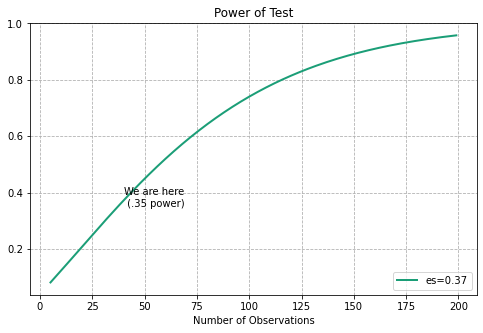

In [84]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

fig = TTestIndPower().plot_power(dep_var='nobs',
                                 nobs= np.arange(5, 200),
                                 effect_size=np.array([0.37]),
                                 alpha=0.05,
                                 ax=ax) #title='Power of t-Test' + '\n' + r'$\alpha = 0.01$'
#np.array([0.2, 0.35, 0.5, 0.8]),
ax.annotate("We are here \n (.35 power)", (40, .35))
ax.grid(linestyle = '--')


In [85]:
"""
Total number of participants in 'Highly Desirable': 40
Total number of participants in 'Weakly Desirable': 46
Total number of participants in 'Undesirable': 39
"""

"\nTotal number of participants in 'Highly Desirable': 40\nTotal number of participants in 'Weakly Desirable': 46\nTotal number of participants in 'Undesirable': 39\n"

##### Weakly desirability and Undesirable (Noisy)

In [86]:
stat_U_WD, p_U_WD = stats.levene(decoy_P_U_freq_df["Target(%)"], decoy_P_WD_freq_df["Target(%)"])

print("p_U_WD: " + str(p_U_WD))

stats.ttest_ind(a=decoy_P_U_freq_df["Target(%)"], b=decoy_P_WD_freq_df["Target(%)"], equal_var=True)

p_U_WD: 0.32169253102686823


Ttest_indResult(statistic=-0.914953286406703, pvalue=0.3628666621304373)

In [87]:
PhantNoisy_WDU_ttest_results = ttest_ind(decoy_P_WD_freq_df["Target(%)"], decoy_P_U_freq_df["Target(%)"], alternative="two-sided", usevar="pooled")

print("Phantom Decoy NoisyItems Weakly desirable &  Undesirable: " + "\n t-stat: " + str(round(PhantNoisy_WDU_ttest_results[0], 3)) + "\n p-value: " + str(round(PhantNoisy_WDU_ttest_results[1], 3)) + "\n df: " + str(round(PhantNoisy_WDU_ttest_results[2], 3)))


Phantom Decoy NoisyItems Weakly desirable &  Undesirable: 
 t-stat: 0.915
 p-value: 0.363
 df: 83.0


In [88]:
print("Cohen's d between Weakly desirability and  Undesirability groups: ")
pg.compute_effsize(decoy_P_WD_freq_df["Target(%)"], decoy_P_U_freq_df["Target(%)"], eftype='cohen')

Cohen's d between Weakly desirability and  Undesirability groups: 


0.19915772879761687

##### Highly desirable and Undesirable (Noisy)

In [89]:
stat_HD_U, p_HD_U = stats.levene(decoy_P_HD_freq_df["Target(%)"], decoy_P_U_freq_df["Target(%)"])

print("p_HD_U: " + str(p_HD_U))

stats.ttest_ind(a=decoy_P_HD_freq_df["Target(%)"], b=decoy_P_U_freq_df["Target(%)"], equal_var=True)


p_HD_U: 0.23806287198316395


Ttest_indResult(statistic=2.575762287109483, pvalue=0.01191653907500491)

In [90]:
PhantNoisy_HDU_ttest_results = ttest_ind(decoy_P_HD_freq_df["Target(%)"], decoy_P_U_freq_df["Target(%)"], alternative="two-sided", usevar="pooled")

print("Phantom Decoy NoisyItems Highly desirable &  Undesirable: " + "\n t-stat: " + str(round(PhantNoisy_HDU_ttest_results[0], 3)) + "\n p-value: " + str(round(PhantNoisy_HDU_ttest_results[1], 3)) + "\n df: " + str(round(PhantNoisy_HDU_ttest_results[2], 3)))


Phantom Decoy NoisyItems Highly desirable &  Undesirable: 
 t-stat: 2.576
 p-value: 0.012
 df: 77.0


In [91]:
print("Cohen's d between Highly desirability and  Undesirability groups: ")
pg.compute_effsize(decoy_P_HD_freq_df["Target(%)"], decoy_P_U_freq_df["Target(%)"], eftype='cohen')

Cohen's d between Highly desirability and  Undesirability groups: 


0.5796382367675894

In [92]:
#Power analysis 

powers = np.arange(0.1, 1, .1)

for x in powers:
    sample_size = stats_power.tt_ind_solve_power(effect_size = 0.579, 
                                         nobs1=None,
                                         power = x, 
                                         alpha = 0.05)
    print('Power '+ str(round(x,2)) + ' required sample size: {0:.2f}'.format(sample_size))
    
current_power = stats_power.tt_ind_solve_power(effect_size = 0.579, #Effect size from Cohen's d
                                         nobs1=40, #sample size group 1
                                         ratio=40/39, #ratio between sample1/sample2
                                         power = None, 
                                         alpha = 0.05)

print("\nAt present with a ratio of 40/39 for both group samples, we have a power of : " + str(round(current_power, 3)))


Power 0.1 required sample size: 3.67
Power 0.2 required sample size: 8.45
Power 0.3 required sample size: 13.29
Power 0.4 required sample size: 18.37
Power 0.5 required sample size: 23.91
Power 0.6 required sample size: 30.21
Power 0.7 required sample size: 37.80
Power 0.8 required sample size: 47.80
Power 0.9 required sample size: 63.66

At present with a ratio of 40/39 for both group samples, we have a power of : 0.73


### Still, there appears to be too much noise with the items/stimulus. <br>So, I am running a brief check including only the items that work. 

### Highly Desirable Condition

In [93]:
decoy_P_HD_CI_df = decoy_P_HD_df.loc[(decoy_P_HD_df["Item"]=="Baby stroller") | (decoy_P_HD_df["Item"]=="Dehumidifier") | (decoy_P_HD_df["Item"]=="Electric mop") | (decoy_P_HD_df["Item"]=="Organic fertilizer") | (decoy_P_HD_df["Item"]=="Paint sprayer") | (decoy_P_HD_df["Item"]=="Wifi extender")] 
decoy_P_HD_df_LowC = decoy_P_HD_CI_df[decoy_P_HD_CI_df["CouplingCondition"] == "Low coupling"]
decoy_P_HD_df_HighC = decoy_P_HD_CI_df[decoy_P_HD_CI_df["CouplingCondition"] == "High coupling"]

#"Baby stroller", "Dehumidifier", "Electric mop", "Organic fertilizer", "Paint sprayer"

decoy_P_HD_freq_CI_df = partFreq_PhantomDecoy(decoy_P_HD_CI_df)
decoy_P_HD_LowC_freq_CI_df = partFreq_PhantomDecoy(decoy_P_HD_df_LowC)
decoy_P_HD_HighC_freq_CI_df = partFreq_PhantomDecoy(decoy_P_HD_df_HighC)

total_n = decoy_P_HD_df["Survey_ID"].unique()
number_of_low_coupling = decoy_P_HD_df_LowC["Survey_ID"].unique()
number_of_high_coupling = decoy_P_HD_df_HighC["Survey_ID"].unique()

total_n = int(len(total_n))
number_of_low_coupling = int(len(number_of_low_coupling))
number_of_high_coupling = int(len(number_of_high_coupling))

# Get mean, std, and sem for all participatns.
target_P_HD_CI_mean, target_P_HD_CI_std, target_P_HD_CI_sem = get_decoy_stats(decoy_P_HD_freq_CI_df, "Target(%)", total_n)
competitor_P_HD_CI_mean, competitor_P_HD_CI_std, competitor_P_HD_CI_sem = get_decoy_stats(decoy_P_HD_freq_CI_df, "Competitor(%)", total_n)

# Get mean, std, and sem for 'Low coupling' participatns.
target_P_HD_LowC_CI_mean, target_P_HD_LowC_CI_std, target_P_HD_LowC_CI_sem = get_decoy_stats(decoy_P_HD_LowC_freq_CI_df, "Target(%)", number_of_low_coupling)
competitor_P_HD_LowC_CI_mean, competitor_P_HD_LowC_CI_std, competitor_P_HD_LowC_CI_sem = get_decoy_stats(decoy_P_HD_LowC_freq_CI_df, "Competitor(%)", number_of_low_coupling)

# Get mean, std, and sem for 'High coupling' participatns.
target_P_HD_HighC_CI_mean, target_P_HD_HighC_CI_std, target_P_HD_HighC_CI_sem = get_decoy_stats(decoy_P_HD_HighC_freq_CI_df, "Target(%)", number_of_high_coupling)
competitor_P_HD_HighC_CI_mean, competitor_P_HD_HighC_CI_std, competitor_P_HD_HighC_CI_sem = get_decoy_stats(decoy_P_HD_HighC_freq_CI_df, "Competitor(%)", number_of_high_coupling)

P_HD_summary_df = pd.DataFrame({'Target mean(%)': [target_P_HD_CI_mean, target_P_HD_LowC_CI_mean, target_P_HD_HighC_CI_mean],
                  'Target sem(%)': [target_P_HD_CI_sem, target_P_HD_LowC_CI_sem, target_P_HD_HighC_CI_sem],
                  'Comp mean(%)': [competitor_P_HD_CI_mean, competitor_P_HD_LowC_CI_mean, competitor_P_HD_HighC_CI_mean],
                  'Comp sem(%)': [competitor_P_HD_CI_sem, competitor_P_HD_LowC_CI_sem, competitor_P_HD_HighC_CI_sem]},
                  index=["All", "LowCoupling", "HighCoupling"])

P_HD_summary_df.head()

,Target mean(%),Target sem(%),Comp mean(%),Comp sem(%)
All,59.38,1.98,40.62,1.98
LowCoupling,58.33,2.99,41.67,2.99
HighCoupling,60.32,2.69,39.68,2.69


### Weakly Desirable Condition

In [94]:
decoy_P_WD_CI_df = decoy_P_WD_df.loc[(decoy_P_WD_df["Item"]=="Dehumidifier") | (decoy_P_WD_df["Item"]=="Organic fertilizer") | (decoy_P_WD_df["Item"]=="Paint sprayer") | (decoy_P_WD_df["Item"]=="Wifi extender") | (decoy_P_WD_df["Item"]=="Outdoor solar lights") | (decoy_P_HD_df["Item"]=="Wifi extender")]
decoy_P_WD_df_LowC = decoy_P_WD_df[decoy_P_WD_df["CouplingCondition"] == "Low coupling"]
decoy_P_WD_df_HighC = decoy_P_WD_df[decoy_P_WD_df["CouplingCondition"] == "High coupling"]

decoy_P_WD_freq_CI_df = partFreq_PhantomDecoy(decoy_P_WD_CI_df)
decoy_P_WD_LowC_freq_CI_df = partFreq_PhantomDecoy(decoy_P_WD_df_LowC)
decoy_P_WD_HighC_freq_CI_df = partFreq_PhantomDecoy(decoy_P_WD_df_HighC)

total_n = decoy_P_WD_df["Survey_ID"].unique()
number_of_low_coupling = decoy_P_WD_df_LowC["Survey_ID"].unique()
number_of_high_coupling = decoy_P_WD_df_HighC["Survey_ID"].unique()

total_n = int(len(total_n))
number_of_low_coupling = int(len(number_of_low_coupling))
number_of_high_coupling = int(len(number_of_high_coupling))

# Get mean, std, and sem for all participatns.
target_P_WD_CI_mean, target_P_WD_CI_std, target_P_WD_CI_sem = get_decoy_stats(decoy_P_WD_freq_CI_df, "Target(%)", total_n)
competitor_P_WD_CI_mean, competitor_P_WD_CI_std, competitor_P_WD_CI_sem = get_decoy_stats(decoy_P_WD_freq_CI_df, "Competitor(%)", total_n)

# Get mean, std, and sem for 'Low coupling' participatns.
target_P_WD_LowC_CI_mean, target_P_WD_LowC_CI_std, target_P_WD_LowC_CI_sem = get_decoy_stats(decoy_P_WD_LowC_freq_CI_df, "Target(%)", number_of_low_coupling)
competitor_P_WD_LowC_CI_mean, competitor_P_WD_LowC_CI_std, competitor_P_WD_LowC_CI_sem = get_decoy_stats(decoy_P_WD_LowC_freq_CI_df, "Competitor(%)", number_of_low_coupling)

# Get mean, std, and sem for 'High coupling' participatns.
target_P_WD_HighC_CI_mean, target_P_WD_HighC_CI_std, target_P_WD_HighC_CI_sem = get_decoy_stats(decoy_P_WD_HighC_freq_CI_df, "Target(%)", number_of_high_coupling)
competitor_P_WD_HighC_CI_mean, competitor_P_WD_HighC_CI_std, competitor_P_WD_HighC_CI_sem = get_decoy_stats(decoy_P_WD_HighC_freq_CI_df, "Competitor(%)", number_of_high_coupling)

P_WD_summary_df = pd.DataFrame({'Target mean(%)': [target_P_WD_CI_mean, target_P_WD_LowC_CI_mean, target_P_WD_HighC_CI_mean],
                  'Target sem(%)': [target_P_WD_CI_sem, target_P_WD_LowC_CI_sem, target_P_WD_HighC_CI_sem],
                  'Comp mean(%)': [competitor_P_WD_CI_mean, competitor_P_WD_LowC_CI_mean, competitor_P_WD_HighC_CI_mean],
                  'Comp sem(%)': [competitor_P_WD_CI_sem, competitor_P_WD_LowC_CI_sem, competitor_P_WD_HighC_CI_sem]},
                  index=["All", "LowCoupling", "HighCoupling"])

P_WD_summary_df.head()


,Target mean(%),Target sem(%),Comp mean(%),Comp sem(%)
All,56.43,2.13,43.57,2.13
LowCoupling,52.78,2.66,47.22,2.66
HighCoupling,55.00,2.11,45.00,2.11


### Undesirable Condition

In [95]:
decoy_P_U_CI_df = decoy_P_U_df.loc[(decoy_P_U_df["Item"]=="Dehumidifier") | (decoy_P_U_df["Item"]=="Organic fertilizer") | (decoy_P_U_df["Item"]=="Paint sprayer") | (decoy_P_U_df["Item"]=="Wifi extender") | (decoy_P_U_df["Item"]=="Outdoor solar lights") | (decoy_P_HD_df["Item"]=="Wifi extender")]
decoy_P_U_df_LowC = decoy_P_U_df[decoy_P_U_df["CouplingCondition"] == "Low coupling"]
decoy_P_U_df_HighC = decoy_P_U_df[decoy_P_U_df["CouplingCondition"] == "High coupling"]

decoy_P_U_freq_CI_df = partFreq_PhantomDecoy(decoy_P_U_df)
decoy_P_U_LowC_freq_CI_df = partFreq_PhantomDecoy(decoy_P_U_df_LowC)
decoy_P_U_HighC_freq_CI_df = partFreq_PhantomDecoy(decoy_P_U_df_HighC)

total_n = decoy_P_U_df["Survey_ID"].unique()
number_of_low_coupling = decoy_P_U_df_LowC["Survey_ID"].unique()
number_of_high_coupling = decoy_P_U_df_HighC["Survey_ID"].unique()

total_n = int(len(total_n))
number_of_low_coupling = int(len(number_of_low_coupling))
number_of_high_coupling = int(len(number_of_high_coupling))

# Get mean, std, and sem for all participatns.
target_P_U_CI_mean, target_P_U_CI_std, target_P_U_CI_sem = get_decoy_stats(decoy_P_U_freq_CI_df, "Target(%)", total_n)
competitor_P_U_CI_mean, competitor_P_U_CI_std, competitor_P_U_CI_sem = get_decoy_stats(decoy_P_U_freq_CI_df, "Competitor(%)", total_n)

# Get mean, std, and sem for 'Low coupling' participatns.
target_P_U_LowC_CI_mean, target_P_U_LowC_CI_std, target_P_U_LowC_CI_sem = get_decoy_stats(decoy_P_U_LowC_freq_CI_df, "Target(%)", number_of_low_coupling)
competitor_P_U_LowC_CI_mean, competitor_P_U_LowC_CI_std, competitor_P_U_LowC_CI_sem = get_decoy_stats(decoy_P_U_LowC_freq_CI_df, "Competitor(%)", number_of_low_coupling)

# Get mean, std, and sem for 'High coupling' participatns.
target_P_U_HighC_CI_mean, target_P_U_HighC_CI_std, target_P_U_HighC_CI_sem = get_decoy_stats(decoy_P_U_HighC_freq_CI_df, "Target(%)", number_of_high_coupling)
competitor_P_U_HighC_CI_mean, competitor_P_U_HighC_CI_std, competitor_P_U_HighC_CI_sem = get_decoy_stats(decoy_P_U_HighC_freq_CI_df, "Competitor(%)", number_of_high_coupling)

P_U_summary_df = pd.DataFrame({'Target mean(%)': [target_P_U_CI_mean, target_P_U_LowC_CI_mean, target_P_U_HighC_CI_mean],
                  'Target sem(%)': [target_P_U_CI_sem, target_P_U_LowC_CI_sem, target_P_U_HighC_CI_sem],
                  'Comp mean(%)': [competitor_P_U_CI_mean, competitor_P_U_LowC_CI_mean, competitor_P_U_HighC_CI_mean],
                  'Comp sem(%)': [competitor_P_U_CI_sem, competitor_P_U_LowC_CI_sem, competitor_P_U_HighC_CI_sem]},
                  index=["All", "LowCoupling", "HighCoupling"])

P_U_summary_df.head()

,Target mean(%),Target sem(%),Comp mean(%),Comp sem(%)
All,51.92,1.77,48.08,1.77
LowCoupling,52.71,2.39,47.29,2.39
HighCoupling,50.67,2.62,49.33,2.62


### All phantoms

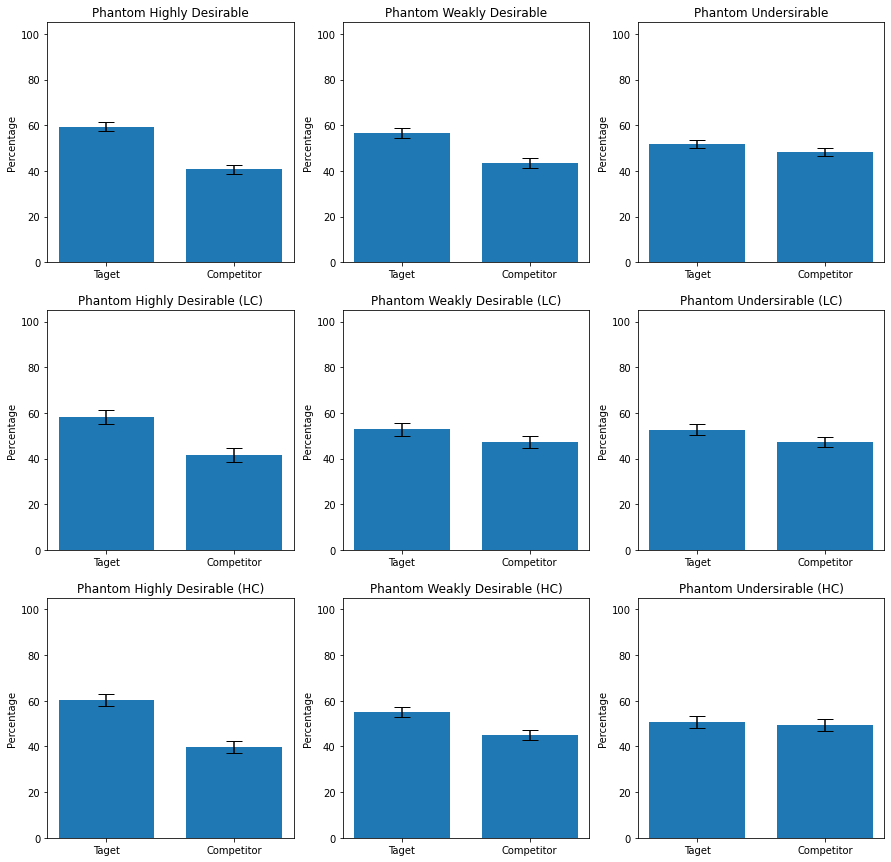

In [96]:
labels = ['Taget', 'Competitor']

x = np.arange(len(labels))

y1 = np.array([target_P_HD_CI_mean, competitor_P_HD_CI_mean])
y2 = np.array([target_P_WD_CI_mean, competitor_P_WD_CI_mean])
y3 = np.array([target_P_U_CI_mean, competitor_P_U_CI_mean])

error1 = np.array([target_P_HD_CI_sem, competitor_P_HD_CI_sem])
error2 = np.array([target_P_WD_CI_sem, competitor_P_WD_CI_sem])
error3 = np.array([target_P_U_CI_sem, competitor_P_U_CI_sem])

y1s = np.array([y1, y2, y3])
errors1 = np.array([error1, error2, error3])

ys = np.array([[[target_P_HD_CI_mean, competitor_P_HD_CI_mean], [target_P_WD_CI_mean, competitor_P_WD_CI_mean], [target_P_U_CI_mean, competitor_P_U_CI_mean]],
              [[target_P_HD_LowC_CI_mean, competitor_P_HD_LowC_CI_mean], [target_P_WD_LowC_CI_mean, competitor_P_WD_LowC_CI_mean], [target_P_U_LowC_CI_mean, competitor_P_U_LowC_CI_mean]], 
              [[target_P_HD_HighC_CI_mean, competitor_P_HD_HighC_CI_mean], [target_P_WD_HighC_CI_mean, competitor_P_WD_HighC_CI_mean], [target_P_U_HighC_CI_mean, competitor_P_U_HighC_CI_mean]]])

errors = np.array([[[target_P_HD_CI_sem, competitor_P_HD_CI_sem], [target_P_WD_CI_sem, competitor_P_WD_CI_sem], [target_P_U_CI_sem, competitor_P_U_CI_sem]],
                  [[target_P_HD_LowC_CI_sem, competitor_P_HD_LowC_CI_sem], [target_P_WD_LowC_CI_sem, competitor_P_WD_LowC_CI_sem], [target_P_U_LowC_CI_sem, competitor_P_U_LowC_CI_sem]],
                  [[target_P_HD_HighC_CI_sem, competitor_P_HD_HighC_CI_sem], [target_P_WD_HighC_CI_sem, competitor_P_WD_HighC_CI_sem], [target_P_U_HighC_CI_sem, competitor_P_U_HighC_CI_sem]]])

titles = [["Phantom Highly Desirable", "Phantom Weakly Desirable", "Phantom Undersirable"],
         ["Phantom Highly Desirable (LC)", "Phantom Weakly Desirable (LC)", "Phantom Undersirable (LC)"],
         ["Phantom Highly Desirable (HC)", "Phantom Weakly Desirable (HC)", "Phantom Undersirable (HC)"]]

fig, ax = plt.subplots(3, 3, figsize=(15, 15))
                       
for x in range(3):
    for y in range(3):
        ax[y][x].bar(labels, ys[y][x], 0.75, yerr=errors[y][x], capsize=8)
        ax[y][x].set_ylim(0, 105)
        ax[y][x].set_ylabel('Percentage')
        ax[y][x].set_title(titles[y][x])
        
plt.show()
# Include only target bars.
# Narrow y-axis (40-80).

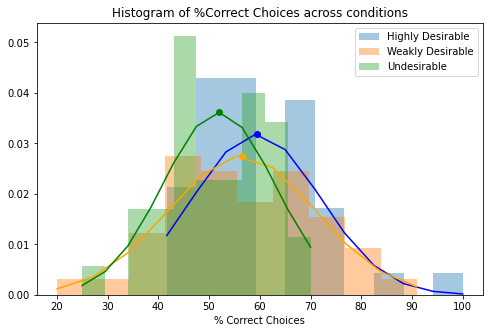

In [97]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

n_HD, bins_HD, patches_HD = ax.hist(decoy_P_HD_freq_CI_df["Target(%)"], density=True, histtype='barstacked', rwidth=None, label="Highly Desirable", alpha=0.4, bins=10)
y_HD = ((1 / (np.sqrt(2 * np.pi) * target_P_HD_CI_std)) * np.exp(-0.5 * (1 / target_P_HD_CI_std * (bins_HD - target_P_HD_CI_mean))**2))
ax.plot(bins_HD, y_HD, color="blue")
ax.plot(target_P_HD_CI_mean, max(y_HD), "ro", color="blue")

n_WD, bins_WD, patches_WD = ax.hist(decoy_P_WD_freq_CI_df["Target(%)"], density=True, histtype='barstacked', rwidth=None, label="Weakly Desirable", alpha=0.4, bins=10)
y_WD = ((1 / (np.sqrt(2 * np.pi) * target_P_WD_CI_std)) * np.exp(-0.5 * (1 / target_P_WD_CI_std * (bins_WD - target_P_WD_CI_mean))**2))
ax.plot(bins_WD, y_WD, color="orange")
ax.plot(target_P_WD_CI_mean, max(y_WD), "ro", color="orange")

n_U, bins_U, patches_U = ax.hist(decoy_P_U_freq_CI_df["Target(%)"], density=True, histtype='barstacked', rwidth=None, label="Undesirable", alpha=0.4, bins=10)
y_U = ((1 / (np.sqrt(2 * np.pi) * target_P_U_CI_std)) * np.exp(-0.5 * (1 / target_P_U_CI_std * (bins_U - target_P_U_CI_mean))**2))
ax.plot(bins_U, y_U, color="green")
ax.plot(target_P_U_CI_mean, max(y_U), "ro", color="green")

ax.set_title("Histogram of %Correct Choices across conditions")
ax.set_xlabel('% Correct Choices')
ax.legend()
plt.show()


<ErrorbarContainer object of 3 artists>

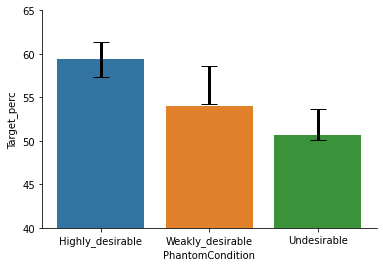

In [103]:
decoy_P_part_df = decoy_P_df.loc[(decoy_P_df["Item"]=="Baby stroller") | (decoy_P_df["Item"]=="Dehumidifier") | (decoy_P_df["Item"]=="Electric mop") | (decoy_P_df["Item"]=="Organic fertilizer") | (decoy_P_df["Item"]=="Paint sprayer") | (decoy_P_df["Item"]=="Wifi extender")] 
decoy_P_part_LessNoisy_df = partFreq_PhantomDecoyWCondition(decoy_P_part_df)

sns_y = np.array([target_P_HD_CI_mean, target_P_WD_CI_mean, target_P_U_CI_mean])
sns_x = ["Highly_desirable", "Weakly_desirable", "Undesirable"]
sns_error = np.array([target_P_HD_CI_sem, target_P_WD_CI_sem, target_P_U_CI_sem])

PNBar2 = sns.barplot(x="PhantomCondition", y="Target_perc",
            order=["Highly_desirable", "Weakly_desirable", "Undesirable"],
            ci=None,
            data=decoy_P_part_LessNoisy_df) #kind="bar", ci=None,
PNBar2.set(ylim=(40, 65))
sns.despine()

bars2 = PNBar.errorbar(x=sns_x, y=sns_y, yerr=sns_error)


xys = bars2.lines[0].get_xydata()
xys2 = np.array([[0, 59.38], [1, 56.43], [2, 51.92]])
#xys3 = xys[:,0] + np.array()
bars2.remove()

PNBar2.errorbar(x=xys[:, 0], y=[target_P_HD_CI_mean, target_P_WD_CI_mean, target_P_U_CI_mean], 
               yerr=[target_P_HD_CI_sem, target_P_WD_CI_sem, target_P_U_CI_sem],
              ls='', lw=3, color='black', capsize=8)


In [99]:
sns_y

array([59.38, 56.43, 51.92])

In [100]:
sns_error

array([1.98, 2.13, 1.77])

In [101]:
xys

array([[ 0.  , 59.38],
       [ 1.  , 56.43],
       [ 2.  , 51.92]])

### Statistical Analysis Phantom Decoys LessNoisyItems

#### All conditions One-way ANOVA


In [120]:
#One-way ANOVA "PhantomCondition" with statsmodels
PhanDecoys_LessNoisy_lm = ols('Target_perc ~ PhantomCondition', data=decoy_P_part_LessNoisy_df).fit()

PhanDecoys_LessNoisy_table = sm.stats.anova_lm(PhanDecoys_LessNoisy_lm)

print(PhanDecoys_LessNoisy_table)

                     df        sum_sq     mean_sq         F    PR(>F)
PhantomCondition    2.0   1540.104747  770.052374  3.689975  0.027801
Residual          122.0  25459.895253  208.687666       NaN       NaN


In [121]:
#One-way ANOVA "CouplingCondition" with statsmodels
PhanDecoys_CoupC_LessNoisy_lm = ols('Target_perc ~ CouplingCondition', data=decoy_P_part_LessNoisy_df).fit()

PhanDecoys_CoupC_LessNoisy_table = sm.stats.anova_lm(PhanDecoys_CoupC_LessNoisy_lm)

print(PhanDecoys_CoupC_LessNoisy_table)

                      df        sum_sq     mean_sq         F    PR(>F)
CouplingCondition    1.0    148.053279  148.053279  0.678184  0.411807
Residual           123.0  26851.946721  218.308510       NaN       NaN


In [122]:
# One-way ANOVA 

f_oneway(decoy_P_HD_freq_CI_df["Target(%)"], decoy_P_WD_freq_CI_df["Target(%)"], decoy_P_U_freq_CI_df["Target(%)"])


F_onewayResult(statistic=3.36044301460113, pvalue=0.03796290349119579)

#### Individual testing

##### Highly desirability and Weakly desirability (LessNoisy)

In [123]:
#Perform two sample t-test with equal variances
stat_HD_WD_CI, p_HD_WD_CI = stats.levene(decoy_P_HD_freq_CI_df["Target(%)"], decoy_P_WD_freq_CI_df["Target(%)"])

print("p_HD_WD_CI: " + str(p_HD_WD_CI))

stats.ttest_ind(a=decoy_P_HD_freq_CI_df["Target(%)"], b=decoy_P_WD_freq_CI_df["Target(%)"], equal_var=True)


p_HD_WD_CI: 0.2096971678690332


Ttest_indResult(statistic=1.001096720174051, pvalue=0.31965520610996145)

In [124]:
PhantLessNoisy_HDWD_ttest_results = ttest_ind(decoy_P_HD_freq_CI_df["Target(%)"], decoy_P_WD_freq_CI_df["Target(%)"], alternative="two-sided", usevar="pooled")

print("Phantom Decoy LessNoisyItems Highly desirable & Weakly desirable: " + "\n t-stat: " + str(round(PhantLessNoisy_HDWD_ttest_results[0], 3)) + "\n p-value: " + str(round(PhantLessNoisy_HDWD_ttest_results[1], 3)) + "\n df: " + str(round(PhantLessNoisy_HDWD_ttest_results[2], 3)))


Phantom Decoy LessNoisyItems Highly desirable & Weakly desirable: 
 t-stat: 1.001
 p-value: 0.32
 df: 84.0


In [125]:
print("Cohen's d between Highly desirable and Weakly desirable groups: ")
pg.compute_effsize(decoy_P_HD_freq_CI_df["Target(%)"], decoy_P_WD_freq_CI_df["Target(%)"], eftype='cohen')

Cohen's d between Highly desirable and Weakly desirable groups: 


0.2164294484281481

In [126]:
#Power analysis 

powers = np.arange(0.1, 1, .1)

for x in powers:
    sample_size = stats_power.tt_ind_solve_power(effect_size=0.216, 
                                         nobs1=None,
                                         power = x, 
                                         alpha = 0.05)
    print('Power '+ str(round(x,2)) + ' required sample size: {0:.2f}'.format(sample_size))
    
current_power = stats_power.tt_ind_solve_power(effect_size=0.216, #Effect size from Cohen's d
                                         nobs1=40, #sample size group 1
                                         ratio=40/46, #ratio between sample1/sample2
                                         power = None, 
                                         alpha = 0.05)

print("\nAt present with a ratio of 46/39 for both group samples, we have a power of : " + str(round(current_power, 3)))


Power 0.1 required sample size: 19.23
Power 0.2 required sample size: 54.22
Power 0.3 required sample size: 89.19
Power 0.4 required sample size: 125.77
Power 0.5 required sample size: 165.62
Power 0.6 required sample size: 210.95
Power 0.7 required sample size: 265.54
Power 0.8 required sample size: 337.42
Power 0.9 required sample size: 451.38

At present with a ratio of 46/39 for both group samples, we have a power of : 0.151


##### Weakly desirability and Undesirable (LessNoisy)

In [127]:
stat_WD_U_CI, p_WD_U_CI = stats.levene(decoy_P_WD_freq_CI_df["Target(%)"], decoy_P_U_freq_CI_df["Target(%)"])

print("p_WD_U_CI: " + str(p_WD_U_CI))

stats.ttest_ind(a=decoy_P_WD_freq_CI_df["Target(%)"], b=decoy_P_U_freq_CI_df["Target(%)"], equal_var=True)

p_WD_U_CI: 0.15751038230238612


Ttest_indResult(statistic=1.5911343610175408, pvalue=0.11538114079138027)

In [128]:
PhantLessNoisy_WDU_ttest_results = ttest_ind(decoy_P_WD_freq_CI_df["Target(%)"], decoy_P_U_freq_CI_df["Target(%)"], alternative="two-sided", usevar="pooled")

print("Phantom Decoy LessNoisyItems Weakly desirable & Undesirable: " + "\n t-stat: " + str(round(PhantLessNoisy_WDU_ttest_results[0], 3)) + "\n p-value: " + str(round(PhantLessNoisy_WDU_ttest_results[1], 3)) + "\n df: " + str(round(PhantLessNoisy_WDU_ttest_results[2], 3)))


Phantom Decoy LessNoisyItems Weakly desirable & Undesirable: 
 t-stat: 1.591
 p-value: 0.115
 df: 83.0


In [129]:
print("Cohen's d between Weakly desirable and Undesirable groups: ")
pg.compute_effsize(decoy_P_WD_freq_CI_df["Target(%)"], decoy_P_U_freq_CI_df["Target(%)"], eftype='cohen')

Cohen's d between Weakly desirable and Undesirable groups: 


0.34634195019574193

In [130]:
#Power analysis 

powers = np.arange(0.1, 1, .1)

for x in powers:
    sample_size = stats_power.tt_ind_solve_power(effect_size=0.346, 
                                         nobs1=None,
                                         power = x, 
                                         alpha = 0.05)
    print('Power '+ str(round(x,2)) + ' required sample size: {0:.2f}'.format(sample_size))
    
current_power = stats_power.tt_ind_solve_power(effect_size=0.346, #Effect size from Cohen's d
                                         nobs1=46, #sample size group 1
                                         ratio=46/39, #ratio between sample1/sample2
                                         power = None, 
                                         alpha = 0.05)

print("\nAt present with a ratio of 46/39 for both group samples, we have a power of : " + str(round(current_power, 3)))


Power 0.1 required sample size: 8.14
Power 0.2 required sample size: 21.74
Power 0.3 required sample size: 35.36
Power 0.4 required sample size: 49.61
Power 0.5 required sample size: 65.14
Power 0.6 required sample size: 82.81
Power 0.7 required sample size: 104.08
Power 0.8 required sample size: 132.09
Power 0.9 required sample size: 176.51

At present with a ratio of 46/39 for both group samples, we have a power of : 0.401


##### Highly desirability and  Undesirable (LessNoisy)

In [131]:
stat_HD_U_CI, p_HD_U_CI = stats.levene(decoy_P_HD_freq_CI_df["Target(%)"], decoy_P_U_freq_CI_df["Target(%)"])

print("p_HD_U_CI: " + str(p_HD_U_CI))

stats.ttest_ind(a=decoy_P_HD_freq_CI_df["Target(%)"], b=decoy_P_U_freq_CI_df["Target(%)"], equal_var=True)

p_HD_U_CI: 0.9921655482506276


Ttest_indResult(statistic=2.800248212415819, pvalue=0.006452525140823083)

In [132]:
PhantLessNoisy_HDU_ttest_results = ttest_ind(decoy_P_HD_freq_CI_df["Target(%)"], decoy_P_U_freq_CI_df["Target(%)"], alternative="two-sided", usevar="pooled")

print("Phantom Decoy LessNoisyItems Highly desirable & Undesirable: " + "\n t-stat: " + str(round(PhantLessNoisy_HDU_ttest_results[0], 3)) + "\n p-value: " + str(round(PhantLessNoisy_HDU_ttest_results[1], 3)) + "\n df: " + str(round(PhantLessNoisy_HDU_ttest_results[2], 3)))


Phantom Decoy LessNoisyItems Highly desirable & Undesirable: 
 t-stat: 2.8
 p-value: 0.006
 df: 77.0


In [133]:
print("Cohen's d between Highly desirable and Undesirable groups: ")
pg.compute_effsize(decoy_P_HD_freq_CI_df["Target(%)"], decoy_P_U_freq_CI_df["Target(%)"], eftype='cohen')

Cohen's d between Highly desirable and Undesirable groups: 


0.6301555638419472

In [134]:
#Power analysis 

powers = np.arange(0.1, 1, .1)

for x in powers:
    sample_size = stats_power.tt_ind_solve_power(effect_size = 0.630, 
                                         nobs1=None,
                                         power = x, 
                                         alpha = 0.05)
    print('Power '+ str(round(x,2)) + ' required sample size: {0:.2f}'.format(sample_size))
    
current_power = stats_power.tt_ind_solve_power(effect_size = 0.630, #Effect size from Cohen's d
                                         nobs1=40, #sample size group 1
                                         ratio=40/39, #ratio between sample1/sample2
                                         power = None, 
                                         alpha = 0.05)

print("\nAt present with a ratio of 40/39 for both group samples, we have a power of : " + str(round(current_power, 3)))


Power 0.1 required sample size: 3.29
Power 0.2 required sample size: 7.31
Power 0.3 required sample size: 11.39
Power 0.4 required sample size: 15.68
Power 0.5 required sample size: 20.35
Power 0.6 required sample size: 25.68
Power 0.7 required sample size: 32.09
Power 0.8 required sample size: 40.53
Power 0.9 required sample size: 53.93

At present with a ratio of 40/39 for both group samples, we have a power of : 0.8


In [135]:
"""
Total number of participants in 'Highly Desirable': 40
Total number of participants in 'Weakly Desirable': 46
Total number of participants in 'Undesirable': 39
"""

"\nTotal number of participants in 'Highly Desirable': 40\nTotal number of participants in 'Weakly Desirable': 46\nTotal number of participants in 'Undesirable': 39\n"

## Inspecting Individual Items

### Similarity Decoy

In [136]:
decoy_S_TargetA_df = decoy_S_df.loc[decoy_S_df['Option_1'].str.contains('S_A') | decoy_S_df['Option_2'].str.contains('S_A') | decoy_S_df['Option_3'].str.contains('S_A')]
decoy_S_TargetB_df = decoy_S_df.loc[decoy_S_df['Option_1'].str.contains('S_B') | decoy_S_df['Option_2'].str.contains('S_B') | decoy_S_df['Option_3'].str.contains('S_B')]

decoy_S_Items_TargetA_df = itemFreq_Decoy(decoy_S_TargetA_df, "Sim_Decoy")
decoy_S_Items_TargetB_df = itemFreq_Decoy(decoy_S_TargetB_df, "Sim_Decoy")

item_list = decoy_S_TargetA_df["Item"].unique()
item_list = np.sort(item_list)

Sim_items_targets_A = np.array([])
Sim_items_competitors_A = np.array([])
Sim_items_decoys_A = np.array([])

Sim_items_targets_B = np.array([])
Sim_items_competitors_B = np.array([])
Sim_items_decoys_B = np.array([])

Sim_items_targets_A_sem = np.array([])
Sim_items_competitors_A_sem = np.array([])
Sim_items_decoys_A_sem = np.array([])

Sim_items_targets_B_sem = np.array([])
Sim_items_competitors_B_sem = np.array([])
Sim_items_decoys_B_sem = np.array([])

for item in item_list:
    
    current_item_A = decoy_S_Items_TargetA_df[decoy_S_Items_TargetA_df["Item"] == item]
    current_item_B = decoy_S_Items_TargetB_df[decoy_S_Items_TargetB_df["Item"] == item]
    
    Sim_items_targets_A = np.append(Sim_items_targets_A, current_item_A["Target(%)"])
    Sim_items_competitors_A = np.append(Sim_items_competitors_A, current_item_A["Competitor(%)"])
    Sim_items_decoys_A = np.append(Sim_items_decoys_A, current_item_A["Sim_Decoy(%)"])
    
    Sim_items_targets_B = np.append(Sim_items_targets_B, current_item_B["Target(%)"])
    Sim_items_competitors_B = np.append(Sim_items_competitors_B, current_item_B["Competitor(%)"])
    Sim_items_decoys_B = np.append(Sim_items_decoys_B, current_item_B["Sim_Decoy(%)"])
    
    target_P_WD_std = decoy_P_WD_freq_df["Target(%)"].std()
    competitor_P_WD_std = decoy_P_WD_freq_df["Competitor(%)"].std()

    target_P_WD_sem = round((target_P_WD_std/np.sqrt(total_n)), 2)
    competitor_P_WD_sem = round((competitor_P_WD_std/np.sqrt(total_n)), 2)
    

In [137]:
decoy_S_Items_TargetA_df.sort_values(by=['Item'], inplace=True) 
#decoy_S_Items_TargetA_df.head(10)

In [138]:
decoy_S_Items_TargetB_df.sort_values(by=['Item'], inplace=True) 
#decoy_S_Items_TargetB_df.head(10)

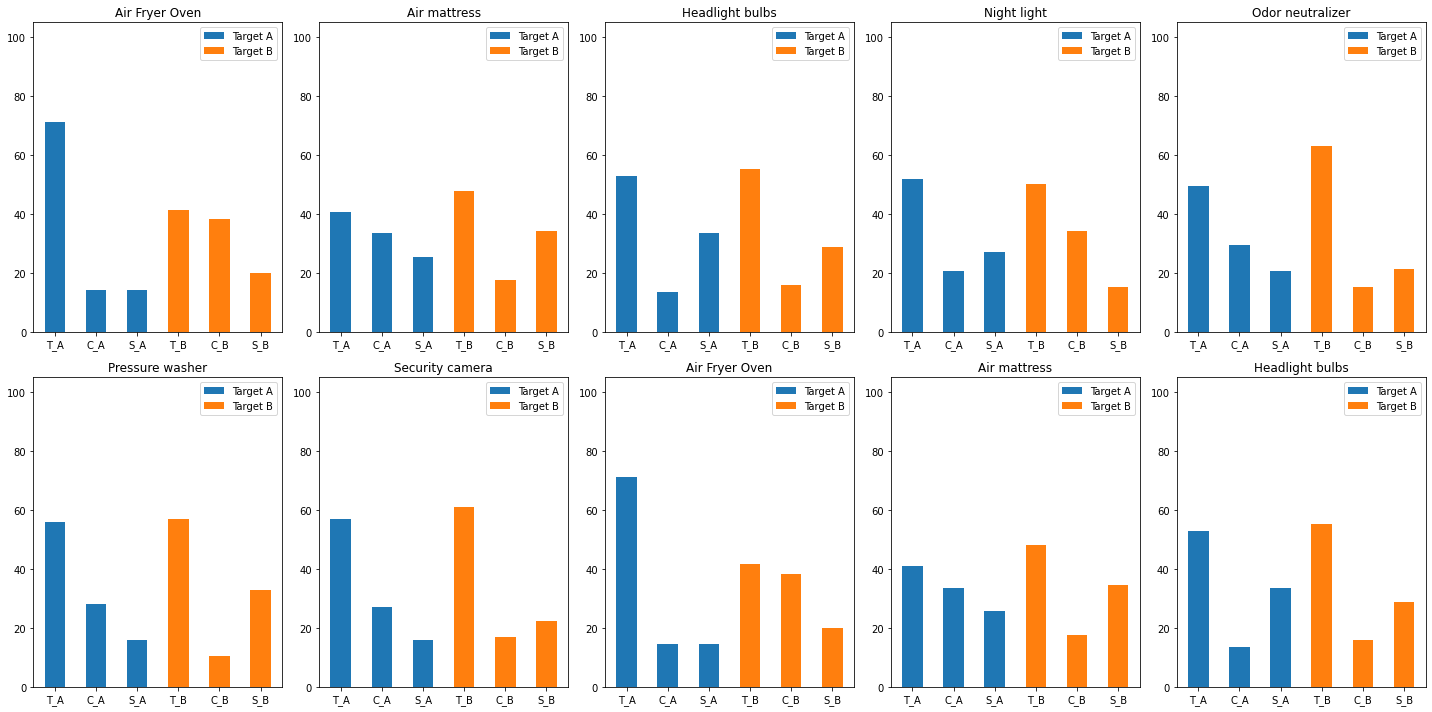

In [139]:
fig, ax = plt.subplots(2, 5, figsize=(20, 10))

# Biased items: "Baby high chair", "Metal detector", "Vacuum"

counter = 0

labels1 = ["T_A", "C_A", "S_A"]
labels2 = ["T_B", "C_B", "S_B"]

n = Sim_items_targets_A.shape[0]

for x in range(2):
    
    for xi in range(5):
        
        if (counter == (n)):
            counter = 0
        
        y1 = np.array([Sim_items_targets_A[counter], Sim_items_competitors_A[counter], Sim_items_decoys_A[counter]])
        y2 = np.array([Sim_items_targets_B[counter], Sim_items_competitors_B[counter], Sim_items_decoys_B[counter]])
        ax[x][xi].bar(labels1, y1, 0.5, capsize=8, label="Target A")
        ax[x][xi].bar(labels2, y2, 0.5, capsize=8, label="Target B")
        ax[x][xi].set_ylim(0, 105)
        ax[x][xi].set_title(item_list[counter])
        ax[x][xi].legend()
        counter = counter + 1

plt.tight_layout()

### Compromise Decoy

In [140]:
decoy_C_TargetA_df = decoy_C_df.loc[decoy_C_df['Option_1'].str.contains('C_A') | decoy_C_df['Option_2'].str.contains('C_A') | decoy_C_df['Option_3'].str.contains('C_A')]
decoy_C_TargetB_df = decoy_C_df.loc[decoy_C_df['Option_1'].str.contains('C_B') | decoy_C_df['Option_2'].str.contains('C_B') | decoy_C_df['Option_3'].str.contains('C_B')]

decoy_C_Items_TargetA_df = itemFreq_Decoy(decoy_C_TargetA_df, "Com_Decoy")
decoy_C_Items_TargetB_df = itemFreq_Decoy(decoy_C_TargetB_df, "Com_Decoy")

item_list = decoy_C_TargetA_df["Item"].unique()
item_list = np.sort(item_list)

Com_items_targets_A = np.array([])
Com_items_competitors_A = np.array([])
Com_items_decoys_A = np.array([])

Com_items_targets_B = np.array([])
Com_items_competitors_B = np.array([])
Com_items_decoys_B = np.array([])

for item in item_list:
    
    current_item_A = decoy_C_Items_TargetA_df[decoy_C_Items_TargetA_df["Item"] == item]
    current_item_B = decoy_C_Items_TargetB_df[decoy_C_Items_TargetB_df["Item"] == item]
    
    Com_items_targets_A = np.append(Com_items_targets_A, current_item_A["Target(%)"])
    Com_items_competitors_A = np.append(Com_items_competitors_A, current_item_A["Competitor(%)"])
    Com_items_decoys_A = np.append(Com_items_decoys_A, current_item_A["Com_Decoy(%)"])
    
    Com_items_targets_B = np.append(Com_items_targets_B, current_item_B["Target(%)"])
    Com_items_competitors_B = np.append(Com_items_competitors_B, current_item_B["Competitor(%)"])
    Com_items_decoys_B = np.append(Com_items_decoys_B, current_item_B["Com_Decoy(%)"])


In [141]:
decoy_C_Items_TargetA_df.sort_values(by=['Item'], inplace=True) 
#decoy_C_Items_TargetA_df.head(10)

In [142]:
decoy_C_Items_TargetB_df.sort_values(by=['Item'], inplace=True) 
#decoy_C_Items_TargetB_df.head(10)

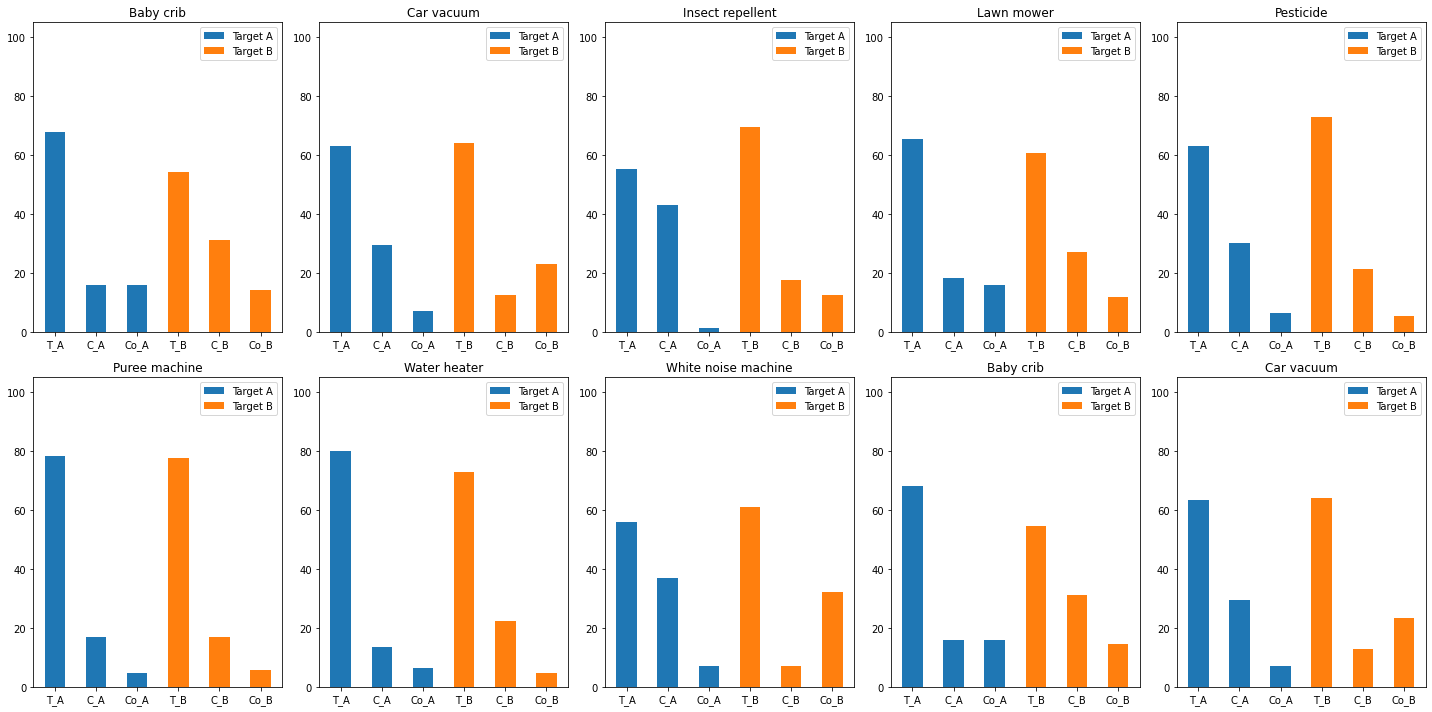

In [143]:
fig, ax = plt.subplots(2, 5, figsize=(20, 10))

# Biased items: "Mobility scooter", "Smart lock"

counter = 0

labels1 = ["T_A", "C_A", "Co_A"]
labels2 = ["T_B", "C_B", "Co_B"]

n = Com_items_targets_A.shape[0]

for x in range(2):
    
    for xi in range(5):
        
        if (counter == (n)):
            counter = 0
        
        y1 = np.array([Com_items_targets_A[counter], Com_items_competitors_A[counter], Com_items_decoys_A[counter]])
        y2 = np.array([Com_items_targets_B[counter], Com_items_competitors_B[counter], Com_items_decoys_B[counter]])
        ax[x][xi].bar(labels1, y1, 0.5, capsize=8, label="Target A")
        ax[x][xi].bar(labels2, y2, 0.5, capsize=8, label="Target B")
        ax[x][xi].set_ylim(0, 105)
        ax[x][xi].set_title(item_list[counter])
        ax[x][xi].legend()
        counter = counter + 1

plt.tight_layout()

### Attraction Decoy

In [144]:
decoy_A_TargetA_df = decoy_A_df.loc[decoy_A_df['Option_1'].str.contains('A_A') | decoy_A_df['Option_2'].str.contains('A_A') | decoy_A_df['Option_3'].str.contains('A_A')]
decoy_A_TargetB_df = decoy_A_df.loc[decoy_A_df['Option_1'].str.contains('A_B') | decoy_A_df['Option_2'].str.contains('A_B') | decoy_A_df['Option_3'].str.contains('A_B')]

decoy_A_Items_TargetA_df = itemFreq_Decoy(decoy_A_TargetA_df, "Att_Decoy")
decoy_A_Items_TargetB_df = itemFreq_Decoy(decoy_A_TargetB_df, "Att_Decoy")

item_list = decoy_A_TargetA_df["Item"].unique()
item_list = np.sort(item_list)

Att_items_targets_A = np.array([])
Att_items_competitors_A = np.array([])
Att_items_decoys_A = np.array([])

Att_items_targets_B = np.array([])
Att_items_competitors_B = np.array([])
Att_items_decoys_B = np.array([])

for item in item_list:
    
    current_item_A = decoy_A_Items_TargetA_df[decoy_A_Items_TargetA_df["Item"] == item]
    current_item_B = decoy_A_Items_TargetB_df[decoy_A_Items_TargetB_df["Item"] == item]
    
    Att_items_targets_A = np.append(Att_items_targets_A, current_item_A["Target(%)"])
    Att_items_competitors_A = np.append(Att_items_competitors_A, current_item_A["Competitor(%)"])
    Att_items_decoys_A = np.append(Att_items_decoys_A, current_item_A["Att_Decoy(%)"])
    
    Att_items_targets_B = np.append(Att_items_targets_B, current_item_B["Target(%)"])
    Att_items_competitors_B = np.append(Att_items_competitors_B, current_item_B["Competitor(%)"])
    Att_items_decoys_B = np.append(Att_items_decoys_B, current_item_B["Att_Decoy(%)"])


In [145]:
decoy_A_Items_TargetA_df.sort_values(by=['Item'], inplace=True) 
#decoy_A_Items_TargetA_df.head(10)

In [146]:
decoy_A_Items_TargetB_df.sort_values(by=['Item'], inplace=True) 
#decoy_A_Items_TargetB_df.head(10)

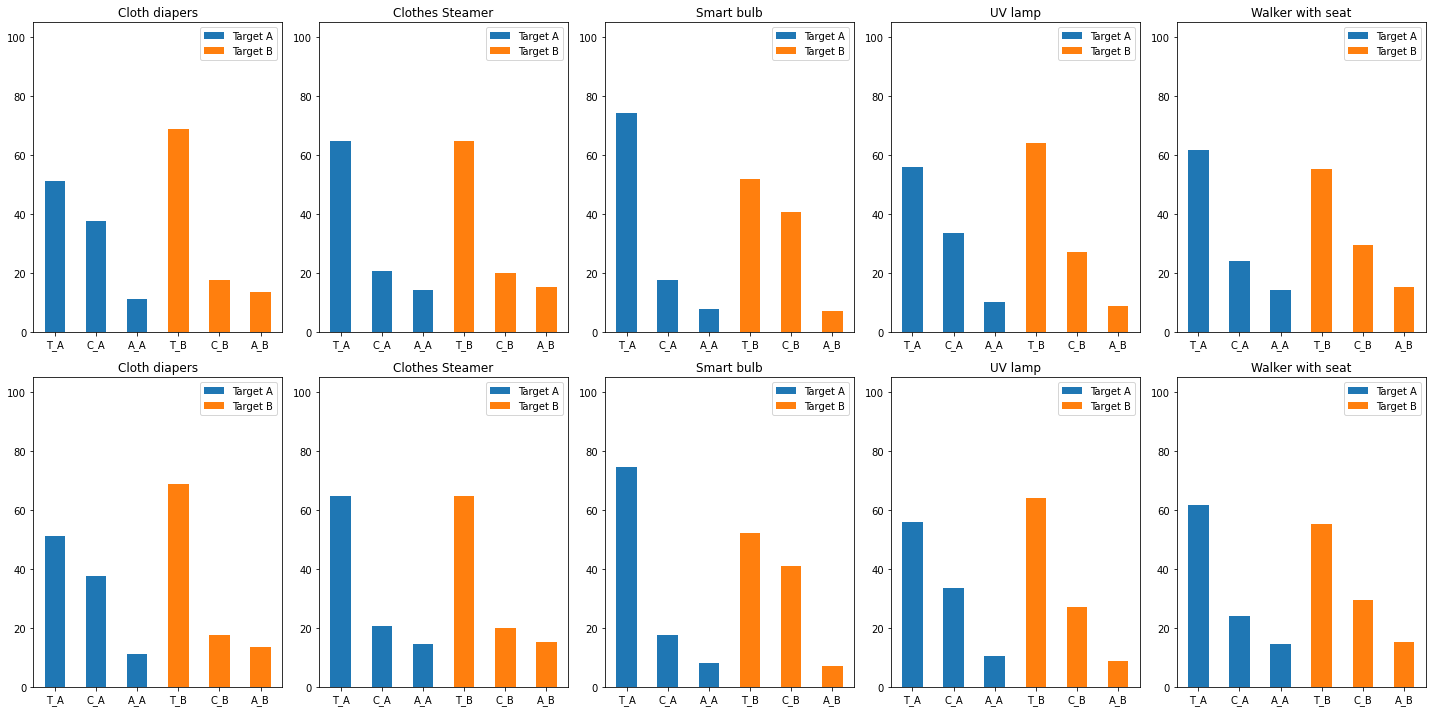

In [147]:
fig, ax = plt.subplots(2, 5, figsize=(20, 10))

# Biased items: "Car seat", "Leaf Blower", "Rash cream", "Slow cooker", "Tire inflator"

counter = 0

labels1 = ["T_A", "C_A", "A_A"]
labels2 = ["T_B", "C_B", "A_B"]

n = Att_items_targets_A.shape[0]

for x in range(2):
    
    for xi in range(5):
        
        if (counter == (n)):
            counter = 0
        
        y1 = np.array([Att_items_targets_A[counter], Att_items_competitors_A[counter], Att_items_decoys_A[counter]])
        y2 = np.array([Att_items_targets_B[counter], Att_items_competitors_B[counter], Att_items_decoys_B[counter]])
        ax[x][xi].bar(labels1, y1, 0.5, capsize=8, label="Target A")
        ax[x][xi].bar(labels2, y2, 0.5, capsize=8, label="Target B")
        ax[x][xi].set_ylim(0, 105)
        ax[x][xi].set_title(item_list[counter])
        ax[x][xi].legend()
        counter = counter + 1

plt.tight_layout()

### Phantom Decoy

In [148]:
decoy_P_TargetA_df = decoy_P_df.loc[decoy_P_df['Option_1'].str.contains('P_A') | decoy_P_df['Option_2'].str.contains('P_A') | decoy_P_df['Option_3'].str.contains('P_A')]
decoy_P_TargetB_df = decoy_P_df.loc[decoy_P_df['Option_1'].str.contains('P_B') | decoy_P_df['Option_2'].str.contains('P_B') | decoy_P_df['Option_3'].str.contains('P_B')]

# Only looking at "Weakly_desirable" condition, as it is sort of a control group.
decoy_P_TargetA_df = decoy_P_TargetA_df[decoy_P_TargetA_df["PhantomCondition"] == "Weakly_desirable"]
decoy_P_TargetB_df = decoy_P_TargetB_df[decoy_P_TargetB_df["PhantomCondition"] == "Weakly_desirable"]

# "Weakly desirable" -> "Dehumidifier", "Organic fertilizer" "Wifi extender"
# "Highly desirable" -> "Baby stroller", "Dehumidifier", "Electric mop", "Organic fertilizer", "Paint sprayer"
# "Undesirable" ->

decoy_P_Items_TargetA_df = itemFreq_PhantomDecoy(decoy_P_TargetA_df)
decoy_P_Items_TargetB_df = itemFreq_PhantomDecoy(decoy_P_TargetB_df)

item_list = decoy_P_TargetA_df["Item"].unique()
item_list = np.sort(item_list)

Phan_items_targets_A = np.array([])
Phan_items_competitors_A = np.array([])

Phan_items_targets_B = np.array([])
Phan_items_competitors_B = np.array([])

for item in item_list:
    
    current_item_A = decoy_P_Items_TargetA_df[decoy_P_Items_TargetA_df["Item"] == item]
    current_item_B = decoy_P_Items_TargetB_df[decoy_P_Items_TargetB_df["Item"] == item]
    
    Phan_items_targets_A = np.append(Phan_items_targets_A, current_item_A["Target(%)"])
    Phan_items_competitors_A = np.append(Phan_items_competitors_A, current_item_A["Competitor(%)"])
    
    Phan_items_targets_B = np.append(Phan_items_targets_B, current_item_B["Target(%)"])
    Phan_items_competitors_B = np.append(Phan_items_competitors_B, current_item_B["Competitor(%)"])

    

In [149]:
decoy_P_Items_TargetB_df.sort_values(by=['Item'], inplace=True) 
decoy_P_Items_TargetB_df.head(10)

,Item,Target(num),Competitor(num),Target(%),Competitor(%)
7,Air purifier,33,13,71.7,28.3
9,Baby stroller,31,15,67.4,32.6
6,Countertop blender,19,27,41.3,58.7
5,Dehumidifier,23,23,50.0,50.0
2,Electric mop,28,18,60.9,39.1
1,Organic fertilizer,25,21,54.3,45.7
0,Outdoor solar lights,35,11,76.1,23.9
3,Paint sprayer,21,25,45.7,54.3
4,Solar panel system,37,9,80.4,19.6
8,Wifi extender,24,22,52.2,47.8


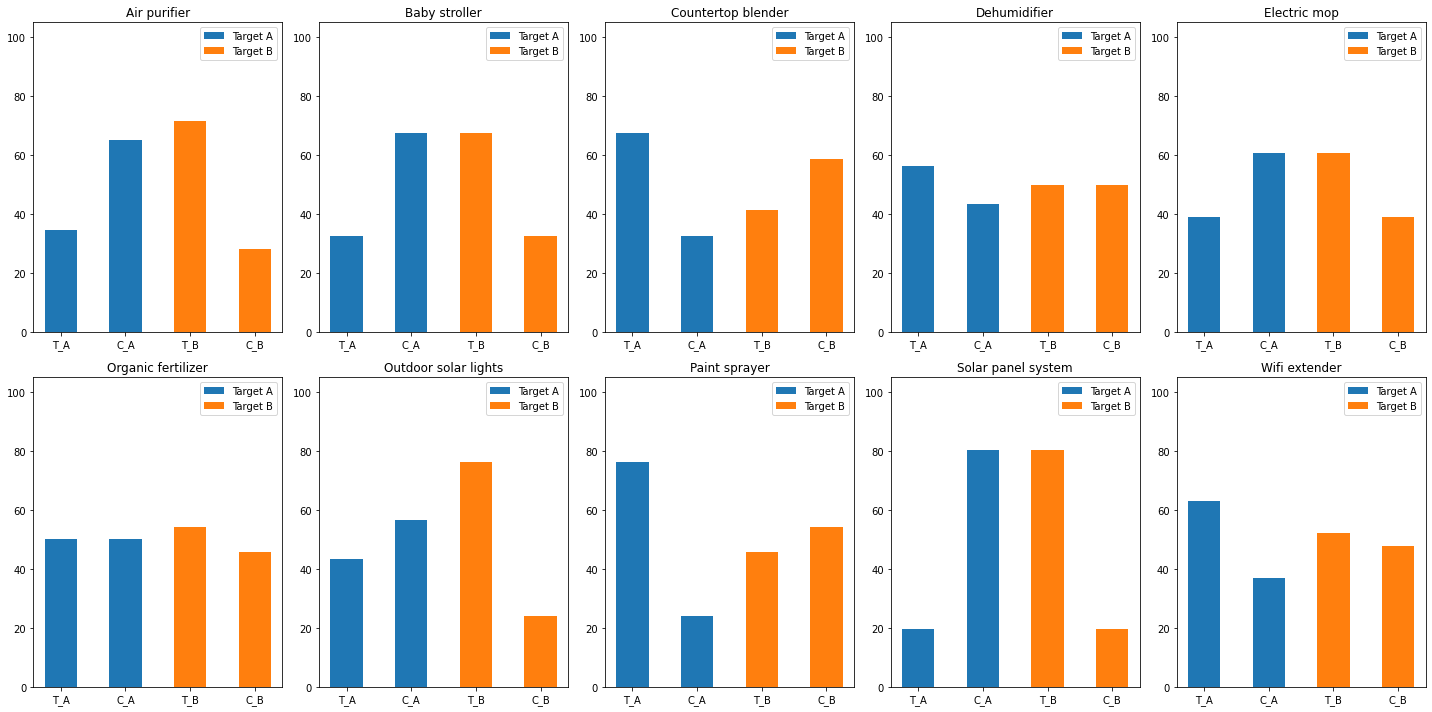

In [150]:
fig, ax = plt.subplots(2, 5, figsize=(20, 10))

counter = 0

labels1 = ["T_A", "C_A"]
labels2 = ["T_B", "C_B"]

n = item_list.shape[0]

for x in range(2):
    
    for xi in range(5):
        
        if (counter == (n)):
            counter = 0
        
        y1 = np.array([Phan_items_targets_A[counter], Phan_items_competitors_A[counter]])
        y2 = np.array([Phan_items_targets_B[counter], Phan_items_competitors_B[counter]])
        ax[x][xi].bar(labels1, y1, 0.5, capsize=8, label="Target A")
        ax[x][xi].bar(labels2, y2, 0.5, capsize=8, label="Target B")
        ax[x][xi].set_ylim(0, 105)
        ax[x][xi].set_title(item_list[counter])
        ax[x][xi].legend()
        counter = counter + 1

plt.tight_layout()